# Выпускной проект: отток клиентов в телеком-компании
**Цель** - обучить модель, выявляющую клиентов, которые с наибольшей вероятностью перестанут пользоваться услугами нашей компании. Целевая метрика, которая будет показателем успешности наших действий - **ROC-AUC** не ниже *0.88*.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


warnings.filterwarnings('ignore')
pd.set_option('max_columns', None)

---

## 1. Первичное изучение и предобработка данных

### 1.1. Загрузка данных
Заготовим функцию, которая упростит нам предобработку данных.

In [2]:
from toads.utils import snake_case


def preproc_pipeline(data):
    """Пайплайн для первичной предобработки данных:
    - Приведение названий столбцов в snake_case;
    - Приведение строковых данных в нижний регистр;
    - Приведение столбцов с yes-no в 1-0."""
    
    # Столбцы в snake case
    data.columns = list(map(snake_case, data.columns))
    
    # Строковые данные в нижний регистр
    obj_cols = data.select_dtypes('object').columns
    data.loc[:, obj_cols] = data[obj_cols].applymap(lambda s: s.lower())
    
    # yes-no приводим к 1-0
    for col in obj_cols:
        if set(data[col].unique()) == {'yes', 'no'}:
            data.loc[:, col] = data[col].map({'yes': 1,
                                              'no': 0})
    
            
    return data

Загрузим датафреймы из всех файлов и применим к ним предобработку с помощью генераторного выражения.

In [3]:
%%time

dataset_names = 'contract', 'internet', 'personal', 'phone'

# Откроем датасеты
contract, internet, personal, phone = (preproc_pipeline(pd.read_csv(f'../../../final/datasets/final_provider/{name}.csv'))
                                       for name in dataset_names)

# Соберём данные в кортеж, чтобы быстрее работать с ними
datasets = contract, internet, personal, phone

# Посмотрим на размеры датафреймов и их вид
for name, df in zip(dataset_names, datasets):
    print(name + ':', df.shape, '\n' + '-' * 20)
    display(df.head(3))

contract: (7043, 8) 
--------------------


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-vhveg,2020-01-01,no,month-to-month,1,electronic check,29.85,29.85
1,5575-gnvde,2017-04-01,no,one year,0,mailed check,56.95,1889.5
2,3668-qpybk,2019-10-01,2019-12-01 00:00:00,month-to-month,1,mailed check,53.85,108.15


internet: (5517, 8) 
--------------------


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-vhveg,dsl,0,1,0,0,0,0
1,5575-gnvde,dsl,1,0,1,0,0,0
2,3668-qpybk,dsl,1,1,0,0,0,0


personal: (7043, 5) 
--------------------


,customer_id,gender,senior_citizen,partner,dependents
0,7590-vhveg,female,0,1,0
1,5575-gnvde,male,0,0,0
2,3668-qpybk,male,0,0,0


phone: (6361, 2) 
--------------------


,customer_id,multiple_lines
0,5575-gnvde,0
1,3668-qpybk,0
2,9237-hqitu,0


CPU times: user 124 ms, sys: 13 ms, total: 137 ms
Wall time: 140 ms


- Мы получили 4 датафрейма, в которых содержится поделённая на части информация о пользователях. Это удобно и экономит хранилище в базе данных, не дублируя информацию.
- Большинство однотипных действий уже сделаны в нашем пайплайне предобработки, и нам не придётся делать их вручную в дальнейшем. Останутся только частные случаи.

Теперь посмотрим на каждый датасет в отдельности и доделаем предобработку.

### 1.2. Договоры

In [4]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   int64  
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 440.3+ KB


In [5]:
contract.head(3)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-vhveg,2020-01-01,no,month-to-month,1,electronic check,29.85,29.85
1,5575-gnvde,2017-04-01,no,one year,0,mailed check,56.95,1889.5
2,3668-qpybk,2019-10-01,2019-12-01 00:00:00,month-to-month,1,mailed check,53.85,108.15


Убедимся, что все id уникальны.

In [6]:
print(f'id пользователей {"не " * (contract.customer_id.nunique() != contract.shape[0])}уникальны')

id пользователей уникальны


Отлично. Теперь доделаем предобработку.

In [7]:
# Столбцы с датами попробуем автоматически привести к datetime
contract.loc[:, ['begin_date', 'end_date']] = pd.concat((pd.to_datetime(s, errors='coerce')
                                                         for s in [contract.begin_date, contract.end_date]), axis=1)

# Принудительно сделаем из суммарной выручки с клиентов числовой тип
contract.total_charges = pd.to_numeric(contract.total_charges, errors='coerce')

# Явно категориальные столбцы переведём в категории
contract.loc[:, ['type', 'payment_method']] = contract[['type', 'payment_method']].astype('category')

# Посмотрим на результат
contract.info()
contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   category      
 4   paperless_billing  7043 non-null   int64         
 5   payment_method     7043 non-null   category      
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
dtypes: category(2), datetime64[ns](2), float64(2), int64(1), object(1)
memory usage: 344.3+ KB


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-vhveg,2020-01-01,NaT,month-to-month,1,electronic check,29.85,29.85
1,5575-gnvde,2017-04-01,NaT,one year,0,mailed check,56.95,1889.50
2,3668-qpybk,2019-10-01,2019-12-01,month-to-month,1,mailed check,53.85,108.15
3,7795-cfocw,2016-05-01,NaT,one year,0,bank transfer (automatic),42.30,1840.75
4,9237-hqitu,2019-09-01,2019-11-01,month-to-month,1,electronic check,70.70,151.65


- Логично предположить, что отсутствие даты расторжения договора свидетельствует о том, что договор до сих пор действует.

Возникает вопрос о том, почему в суммарной выручке есть пропуски. Посмотрим, с чем это может быть связано.

In [8]:
# Выведем клиентов без выручки
contract[contract.total_charges.isna()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-lvygi,2020-02-01,NaT,two year,1,bank transfer (automatic),52.55,NaN
753,3115-czmzd,2020-02-01,NaT,two year,0,mailed check,20.25,NaN
936,5709-lvoeq,2020-02-01,NaT,two year,0,mailed check,80.85,NaN
1082,4367-nuyao,2020-02-01,NaT,two year,0,mailed check,25.75,NaN
1340,1371-dwpaz,2020-02-01,NaT,two year,0,credit card (automatic),56.05,NaN
3331,7644-omvmy,2020-02-01,NaT,two year,0,mailed check,19.85,NaN
3826,3213-vvolg,2020-02-01,NaT,two year,0,mailed check,25.35,NaN
4380,2520-sgtta,2020-02-01,NaT,two year,0,mailed check,20.00,NaN
5218,2923-arzlg,2020-02-01,NaT,one year,1,mailed check,19.70,NaN
6670,4075-wkniu,2020-02-01,NaT,two year,0,mailed check,73.35,NaN


- Видим, что все клиенты начали пользоваться нашими услугами *2020-02-01*. Значит ли это, что это последний день наших данных, и юзеры ещё не успели нам заплатить?

In [9]:
today = contract.begin_date.max()
today

Timestamp('2020-02-01 00:00:00')

Судя по всему, данные актуальны на второе февраля. Заполним платежи нулями, так как мы ещё не получили их. Это будет справедливо. Если нам будут мешать эти данные, мы знаем об этой ситуации и сможем их удалить в будущем. Вполне вероятно, что этот признак нам в принципе не понадобится.

In [10]:
contract.total_charges.fillna(0, inplace=True)

Исходя из контекста дат, есть смысл извлечь столбец с длительностью договора. Вероятно, эти данные будут для нас полезны при обучении модели.

In [11]:
# Посчитаем разницу в днях
# Для незакрытых договоров посчитаем длительность до сегодняшнего дня
contract.loc[:, 'duration_days'] = (contract.end_date.mask(contract.end_date.isna(), today) - contract.begin_date).dt.days.astype('Int64')

# Добавим столбец-маркер расторгнутого договора
contract.loc[:, 'exited'] = contract.end_date.notna().astype(int)

contract.info()
contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   category      
 4   paperless_billing  7043 non-null   int64         
 5   payment_method     7043 non-null   category      
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   duration_days      7043 non-null   Int64         
 9   exited             7043 non-null   int64         
dtypes: Int64(1), category(2), datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 461.2+ KB


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,duration_days,exited
0,7590-vhveg,2020-01-01,NaT,month-to-month,1,electronic check,29.85,29.85,31,0
1,5575-gnvde,2017-04-01,NaT,one year,0,mailed check,56.95,1889.50,1036,0
2,3668-qpybk,2019-10-01,2019-12-01,month-to-month,1,mailed check,53.85,108.15,61,1
3,7795-cfocw,2016-05-01,NaT,one year,0,bank transfer (automatic),42.30,1840.75,1371,0
4,9237-hqitu,2019-09-01,2019-11-01,month-to-month,1,electronic check,70.70,151.65,61,1


- У нас получился красивейший датафрейм с отлично подобранными типами данных и новыми столбцами, сигнализирующими о длительности договора и его актуальности.

### 1.3. Персональные данные

In [12]:
personal.info()
personal.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   int64 
 4   dependents      7043 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 275.2+ KB


,customer_id,gender,senior_citizen,partner,dependents
0,7590-vhveg,female,0,1,0
1,5575-gnvde,male,0,0,0
2,3668-qpybk,male,0,0,0


- Пропуски отсутствуют.
- Видим вполне подходящие типы данных, кроме пола. Изменим его в стиле one-hot.

In [13]:
# Сколько у нас полов? Мало ли)
personal.gender.unique()

array(['female', 'male'], dtype=object)

In [14]:
# Назначим 1 и 0 мужчинам и женщинам соответственно
personal.loc[:, 'is_male'] = personal.gender.map({'female': 0, 'male': 1})
personal.drop('gender', axis=1, inplace=True)
personal.head()

,customer_id,senior_citizen,partner,dependents,is_male
0,7590-vhveg,0,1,0,0
1,5575-gnvde,0,0,0,1
2,3668-qpybk,0,0,0,1
3,7795-cfocw,0,0,0,1
4,9237-hqitu,0,0,0,0


Нам нечего больше делать с этим датафреймом. Перейдём к следующему.

### 1.4. Услуги интернета

In [15]:
internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   int64 
 3   online_backup      5517 non-null   int64 
 4   device_protection  5517 non-null   int64 
 5   tech_support       5517 non-null   int64 
 6   streaming_tv       5517 non-null   int64 
 7   streaming_movies   5517 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 344.9+ KB


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-vhveg,dsl,0,1,0,0,0,0
1,5575-gnvde,dsl,1,0,1,0,0,0
2,3668-qpybk,dsl,1,1,0,0,0,0
3,7795-cfocw,dsl,1,0,1,1,0,0
4,9237-hqitu,fiber optic,0,0,0,0,0,0


- С большинством столбцов всё понятно.

Изучим, какие виды подключения существуют у нашего провайдера.

In [16]:
internet.internet_service.unique()

array(['dsl', 'fiber optic'], dtype=object)

Закодируем их аналогично полу по one-hot.

In [17]:
internet.loc[:, 'optic'] = internet.internet_service.map({'dsl': 0, 'fiber optic': 1}).astype(int)
internet.drop('internet_service', axis=1, inplace=True)
internet.info()
internet.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   online_security    5517 non-null   int64 
 2   online_backup      5517 non-null   int64 
 3   device_protection  5517 non-null   int64 
 4   tech_support       5517 non-null   int64 
 5   streaming_tv       5517 non-null   int64 
 6   streaming_movies   5517 non-null   int64 
 7   optic              5517 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 344.9+ KB


,customer_id,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,optic
0,7590-vhveg,0,1,0,0,0,0,0
1,5575-gnvde,1,0,1,0,0,0,0
2,3668-qpybk,1,1,0,0,0,0,0


Нам осталось проверить последний датафрейм.

### 1.5. Телефония

In [18]:
phone.info()
phone.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 99.5+ KB


,customer_id,multiple_lines
0,5575-gnvde,0
1,3668-qpybk,0
2,9237-hqitu,0
3,9305-cdskc,1
4,1452-kiovk,1


Здесь ничего не нужно предобрабатывать. Всё и так верно.

### 1.6. Дубликаты
Проверим все данные на дубликаты в id пользователей.

In [19]:
for df in datasets:
    print(df.customer_id.duplicated().sum())

0
0
0
0


Как и следовало ожидать, дубликатов нет ни в одном датафрейме.

Теперь можно перейти к анализу данных и поискать в них закономерности.

### 1.7. SQL
Сделаем из датафреймов базу данных `SQLite`, и на этапе анализа мы сможем обращаться к ним при помощи запросов, чтобы сделать код более читаемым и ускорить его работу в сложных местах.

In [20]:
from toads.sql import SQLocal

In [21]:
# Создадим локальную базу данных, в которую поместим наши датафреймы
sql = SQLocal('telecom.db')

# Загрузим датафреймы в базу
for name, df in zip(dataset_names, datasets):
    sql.register_table(name, df)

# Проверим, что всё работает
sql.list_tables()

['baseline', 'contract', 'internet', 'personal', 'phone']

Отлично, теперь для анализа мы сможем пользоваться SQL- запросами.

### Вывод из предобработки данных
- Мы загрузили данные, выполнили рутинные операции с помощью удобного пайплайна предобработки.
- Посмотрели на каждую таблицу по отдельности и доделали предобработку в местах, которые требовали внимания.
- Убедились в отсутствии дубликатов среди id пользователей.
- Загрузили данные в локальную базу SQL, чтобы в дальнейшем иметь возможность обращаться к ним через SQL-запросы.

Перейдём к анализу.

---

## 2. Исследовательский анализ

- Наша **основная задача** - предсказать вероятный уход клиентов. Этот признак содержится в данных о договорах, мы его извлекли из даты расторжения договора.
- Остальные признаки будут помогать нам в предсказаниях. Рассмотрим их по очереди.

Для начала соберём большой датафрейм из всех наших таблиц. Применим для этого SQL-запрос с `left join`, чтобы у нас сохранились все id пользователей.

In [22]:
from toads.image import Img

In [23]:
%%time

# Объединяем все таблицы
data = sql('''select * from contract
join personal using(customer_id)
left join internet using(customer_id)
left join phone using(customer_id)''', parse_dates=['begin_date', 'end_date'])

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   int64         
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   duration_days      7043 non-null   int64         
 9   exited             7043 non-null   int64         
 10  senior_citizen     7043 non-null   int64         
 11  partner            7043 non-null   int64         
 12  dependents         7043 non-null   int64         
 13  is_male            7043 non-null   int64         
 14  online_s

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,duration_days,exited,senior_citizen,partner,dependents,is_male,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,optic,multiple_lines
0,7590-vhveg,2020-01-01,NaT,month-to-month,1,electronic check,29.85,29.85,31,0,0,1,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN
1,5575-gnvde,2017-04-01,NaT,one year,0,mailed check,56.95,1889.50,1036,0,0,0,0,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,3668-qpybk,2019-10-01,2019-12-01,month-to-month,1,mailed check,53.85,108.15,61,1,0,0,0,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7795-cfocw,2016-05-01,NaT,one year,0,bank transfer (automatic),42.30,1840.75,1371,0,0,0,0,1,1.0,0.0,1.0,1.0,0.0,0.0,0.0,NaN
4,9237-hqitu,2019-09-01,2019-11-01,month-to-month,1,electronic check,70.70,151.65,61,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Посмотрим на общее отношение ушедших к остальным.

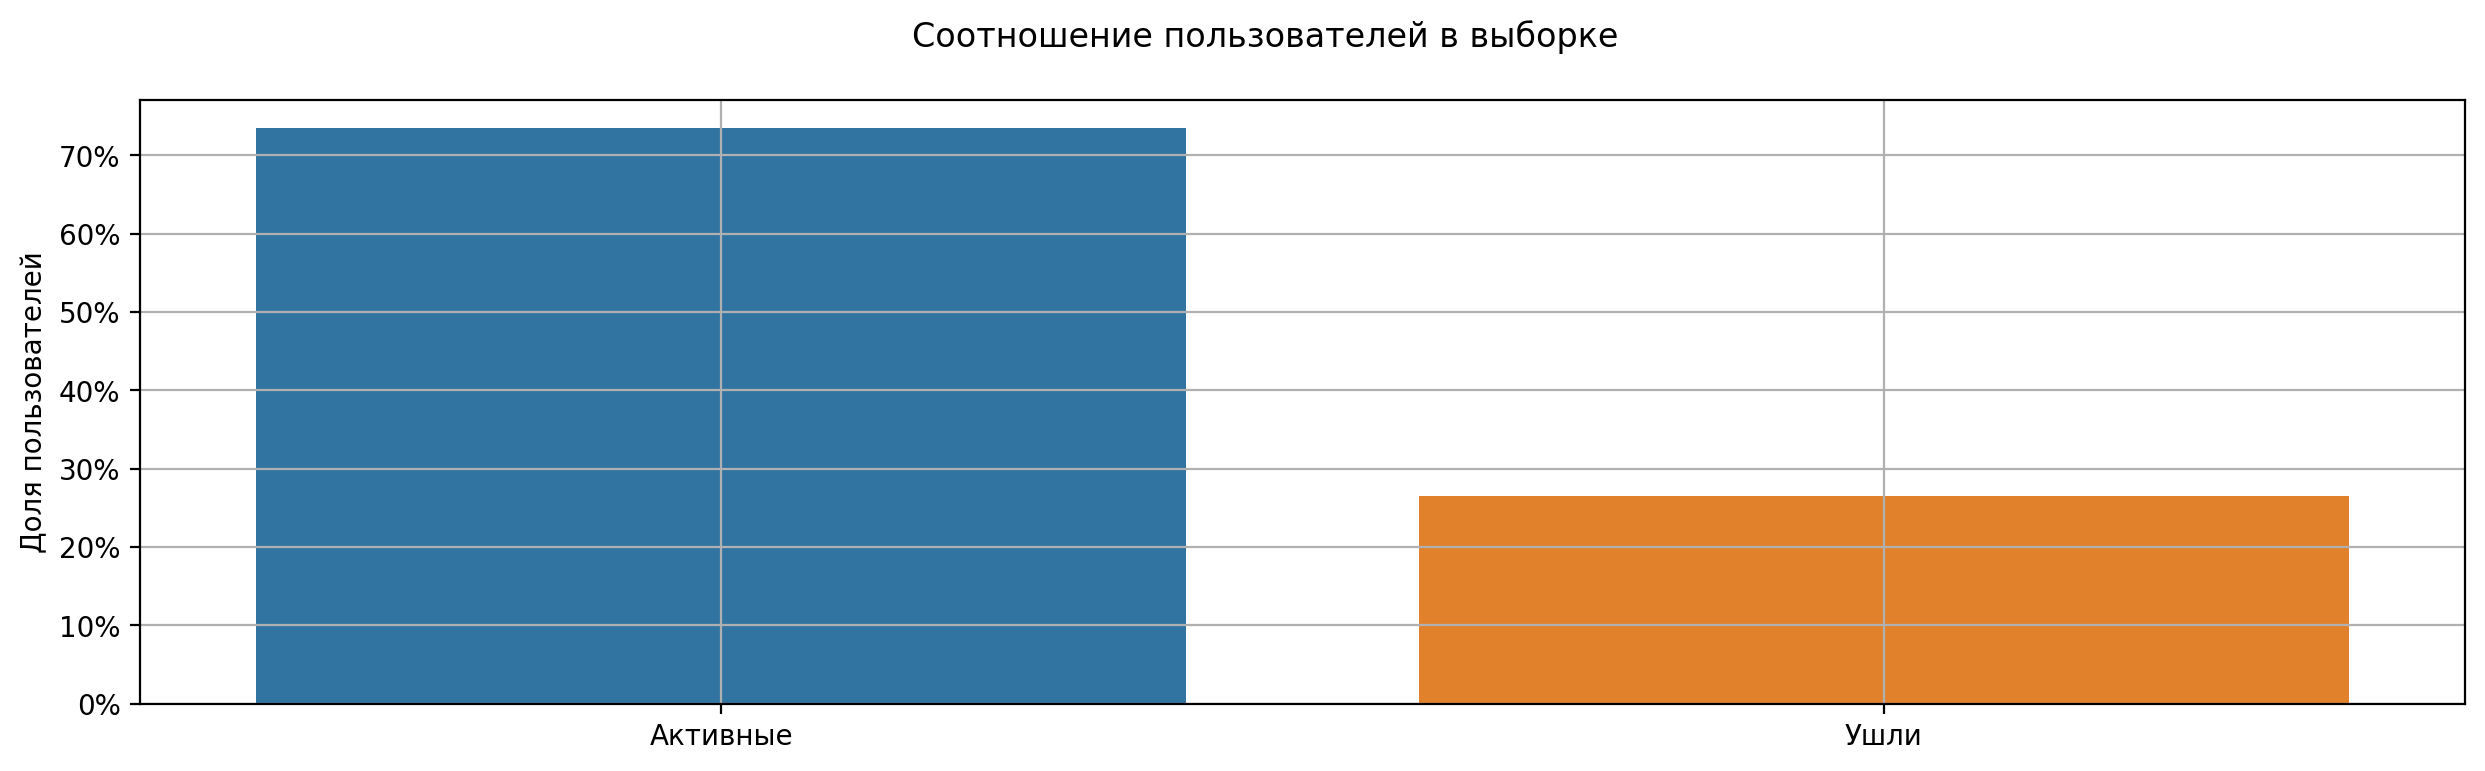

In [24]:
# Нарисуем соотношение пользователей
with Img('Соотношение пользователей в выборке', grid=True):
    sns.barplot(x=[0, 1], y=data.exited.value_counts() / data.shape[0])
    Img.format_axis(1)
    plt.xticks(range(2), ['Активные', 'Ушли'])
    Img.labels(y='Доля пользователей')

- Статистика в выборке не самая приятная: *25%* беглецов. Хочется верить, что в генеральной совокупности всё не так плохо.

Попробуем понять, чем отличаются пользователи, ушедшие и не ушедшие от нас. Построим гистограммы количественных признаков.

### 2.1. Анализ количественных признаков

In [25]:
# Выделим количественные столбцы и целевой признак
numeric_cols = ['monthly_charges', 'total_charges', 'duration_days', 'exited']

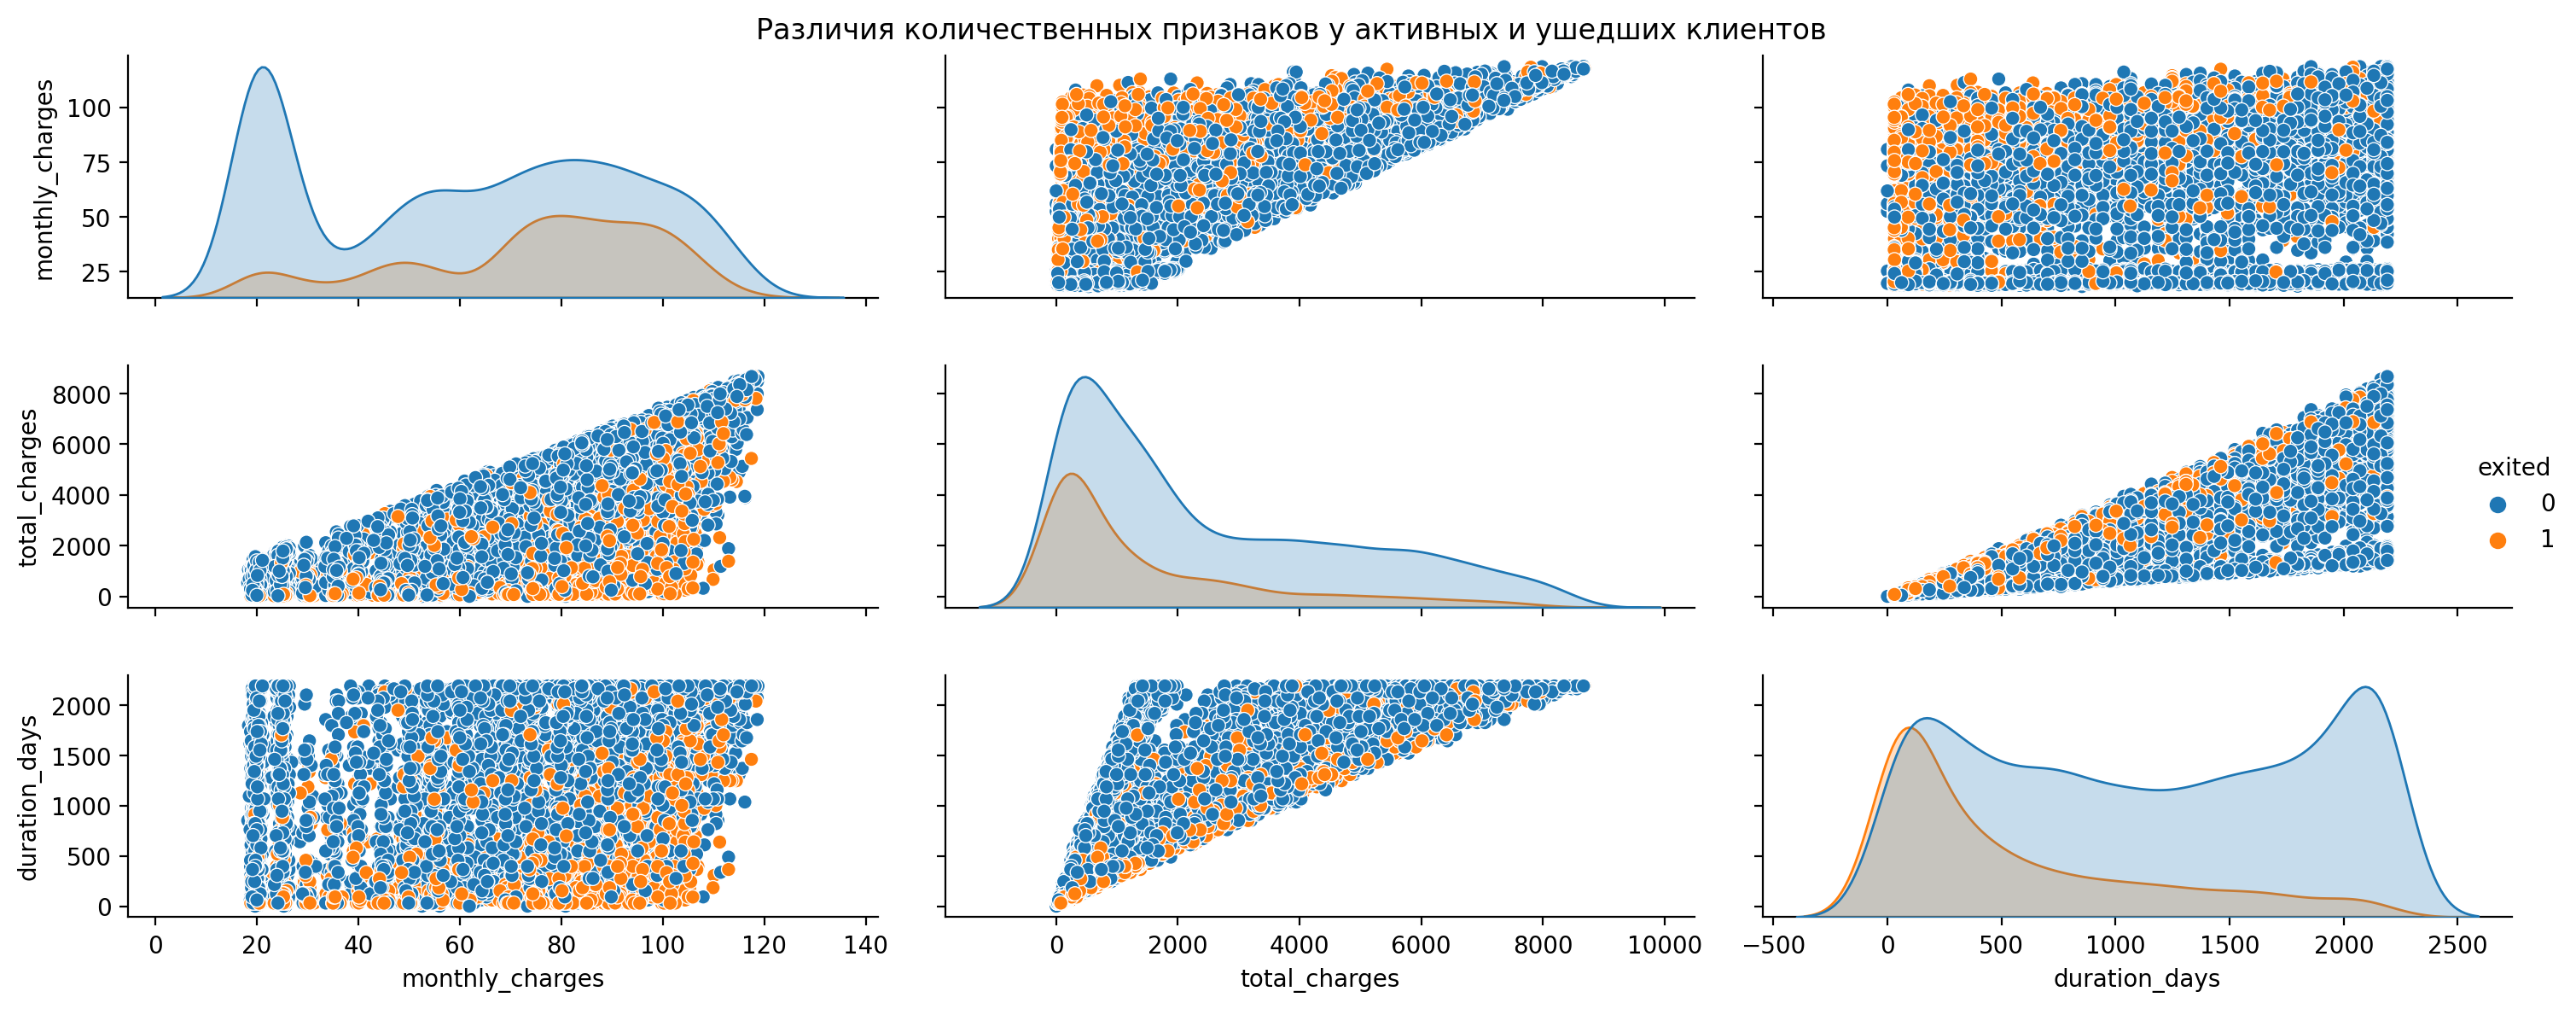

In [26]:
# Посмотрим на количественные признаки
with Img('Различия количественных признаков у активных и ушедших клиентов', tight=True, y=6):
    sns.pairplot(data, vars=['monthly_charges', 'total_charges', 'duration_days'], hue='exited')

Видим, что существует некоторая разница в распределениях:
- У активных клиентов чаще встречается невысокий помесячный платёж.
- Суммарная прибыль с обеих категорий клиентов распределена примерно одинаково.
- Клиенты, которые уходят, чаще делают это в пределах двух лет. Лояльные остаются значительно дольше.
- Отрицательные значения в `duration_days` связаны с особенностями отрисовки. Данные не содержат отрицательных значений.
- Длительность и суммарные платежи выглядят очень взаимосвязанно. Возможно, что нам потребуется отбросить один из этих признаков при обучении модели.

##### Какие из этого можно сделать выводы?
- Клиенты из эконом-категории, вероятно, больше довольны нашими услугами.
- У нас есть трудности с клиентами из денежной категории: те, кто платят много рублей в месяц, вероятно, имеют повышенные требования.
    - *Деление на эконом и денежную категории можно попробовать выполнить с помощью **кластеризации по ежемесячному платежу** - это идея. Тем более, что мы наблюдаем провал на гистограмме `monthly_charges` в районе 40.*
- Если от нас уходят, то по той причине, что, возможно, не находят у нас то, что искали.

Интересно, на какой именно момент времени у нас пришлось большинство ушедших? Построим график временного ряда.

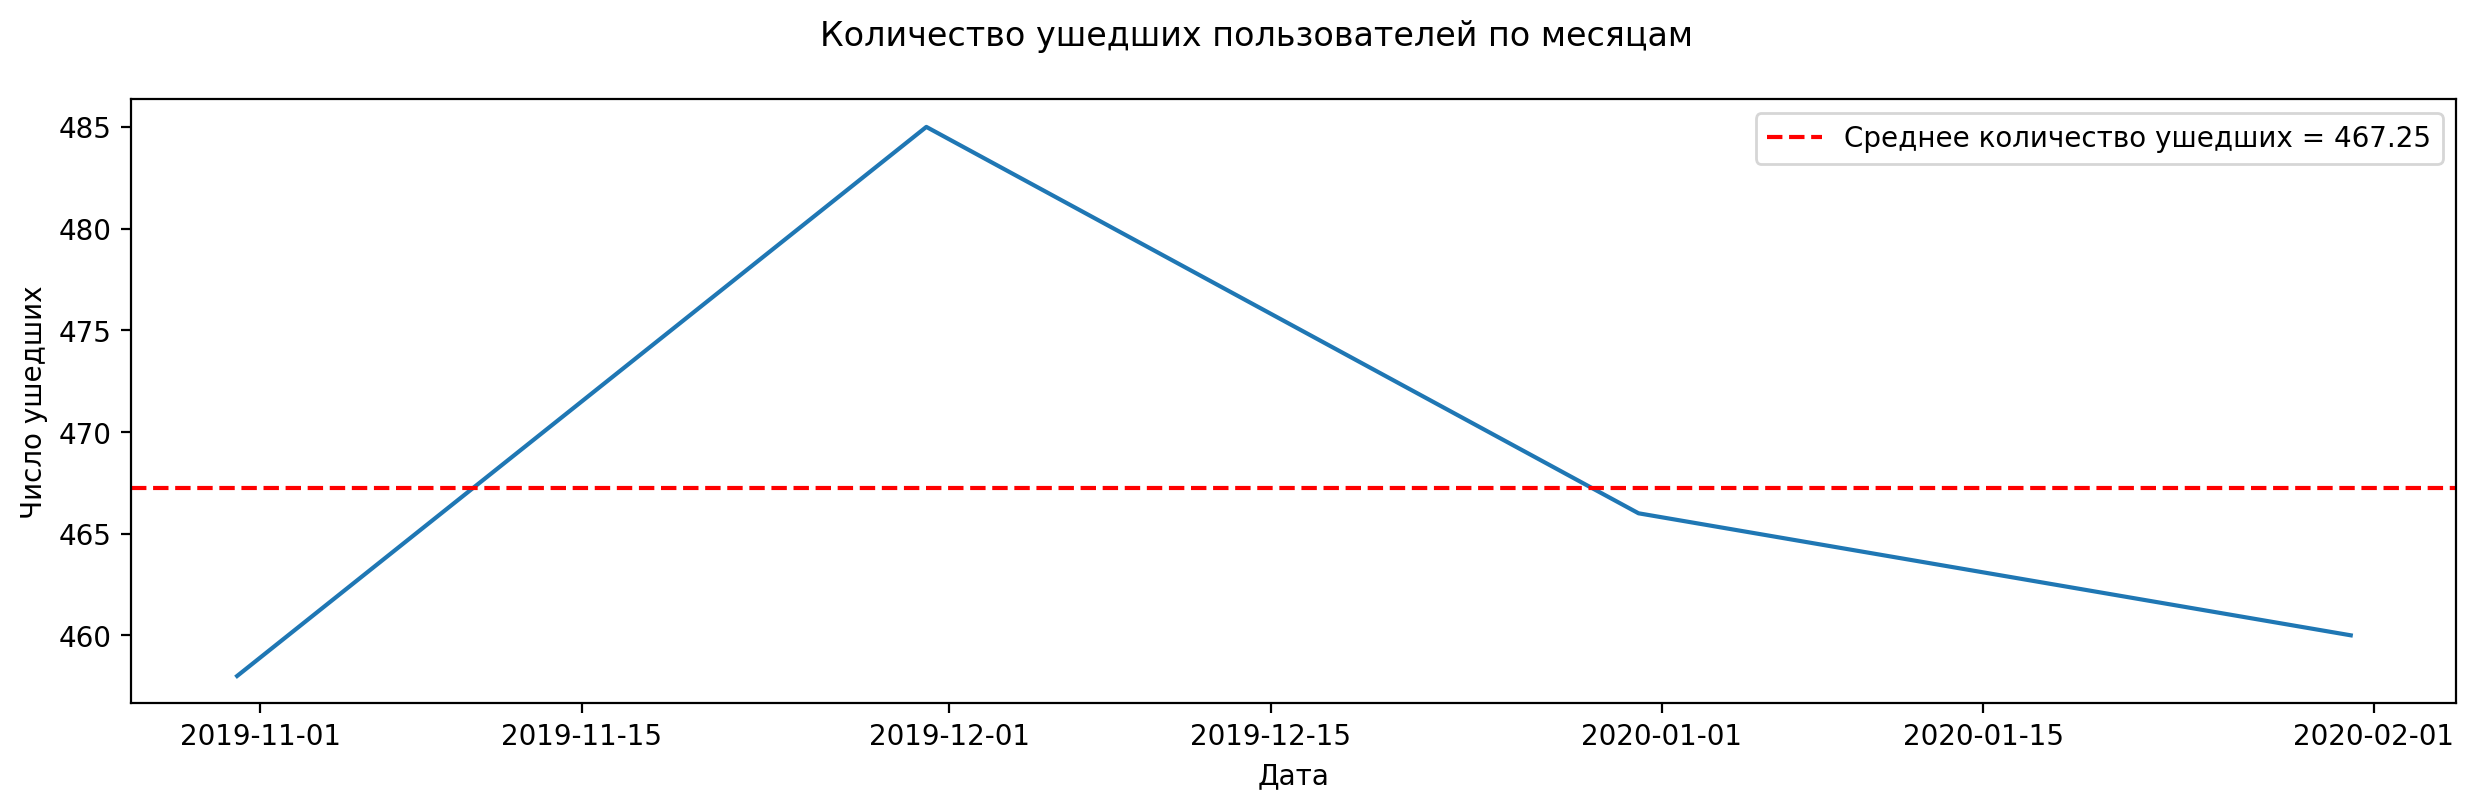

In [27]:
with Img('Количество ушедших пользователей по месяцам', legend='a'):
    exits_monthly = data[['end_date', 'exited']].dropna().set_index('end_date').exited.resample('m').sum()
    sns.lineplot(data=exits_monthly)
    plt.axhline(exits_monthly.mean(), c='r', ls='--', label=f'Среднее количество ушедших = {exits_monthly.mean()}')
    Img.labels('Дата', 'Число ушедших')

- Наблюдаем подъём числа расторгнувших договор в декабре: вполне может быть, что новогодние рекламные акции наших конкурентов с Дмитрием Нагиевым сумели заинтересовать часть наших клиентов.
- У нас не такой большой временной период, чтобы заявлять о месячной сезонности, но будь у нас данные хотя бы за 2-3 года, мы могли бы это проверить и рассматривать месяц как признак.
- Возможно, что наша реклама не настолько сильная, и нам стоило бы сделать для юзеров что-то оригинальное именно в этот период времени.

На данный момент сложно сказать, что нам поможет временной критерий: тем более, мы рискуем получить **утечку данных**, обучив модель на январе и предсказав ею предыдущие два месяца. При обучении мы избавимся от этих признаков и оставим только срок действия договора, потому что он не привязан к конкретному времени.

Посмотрим на категориальные признаки, которыми обладают наши пользователи, и узнаем, какая есть разница в распределениях.

### 2.2. Анализ категориальных признаков

In [28]:
# Выделим список столбцов, где мало значений
cat_cols = data.nunique()[data.nunique() < 5].index.tolist()
cat_cols.remove('exited')
cat_cols.remove('end_date')
cat_cols

['type',
 'paperless_billing',
 'payment_method',
 'senior_citizen',
 'partner',
 'dependents',
 'is_male',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'optic',
 'multiple_lines']

Построим столбчатые диаграммы с подсчётом каждого признака для активных и ушедших и наложим их друг на друга: так мы увидим признаки, которые характерны у наших классов.

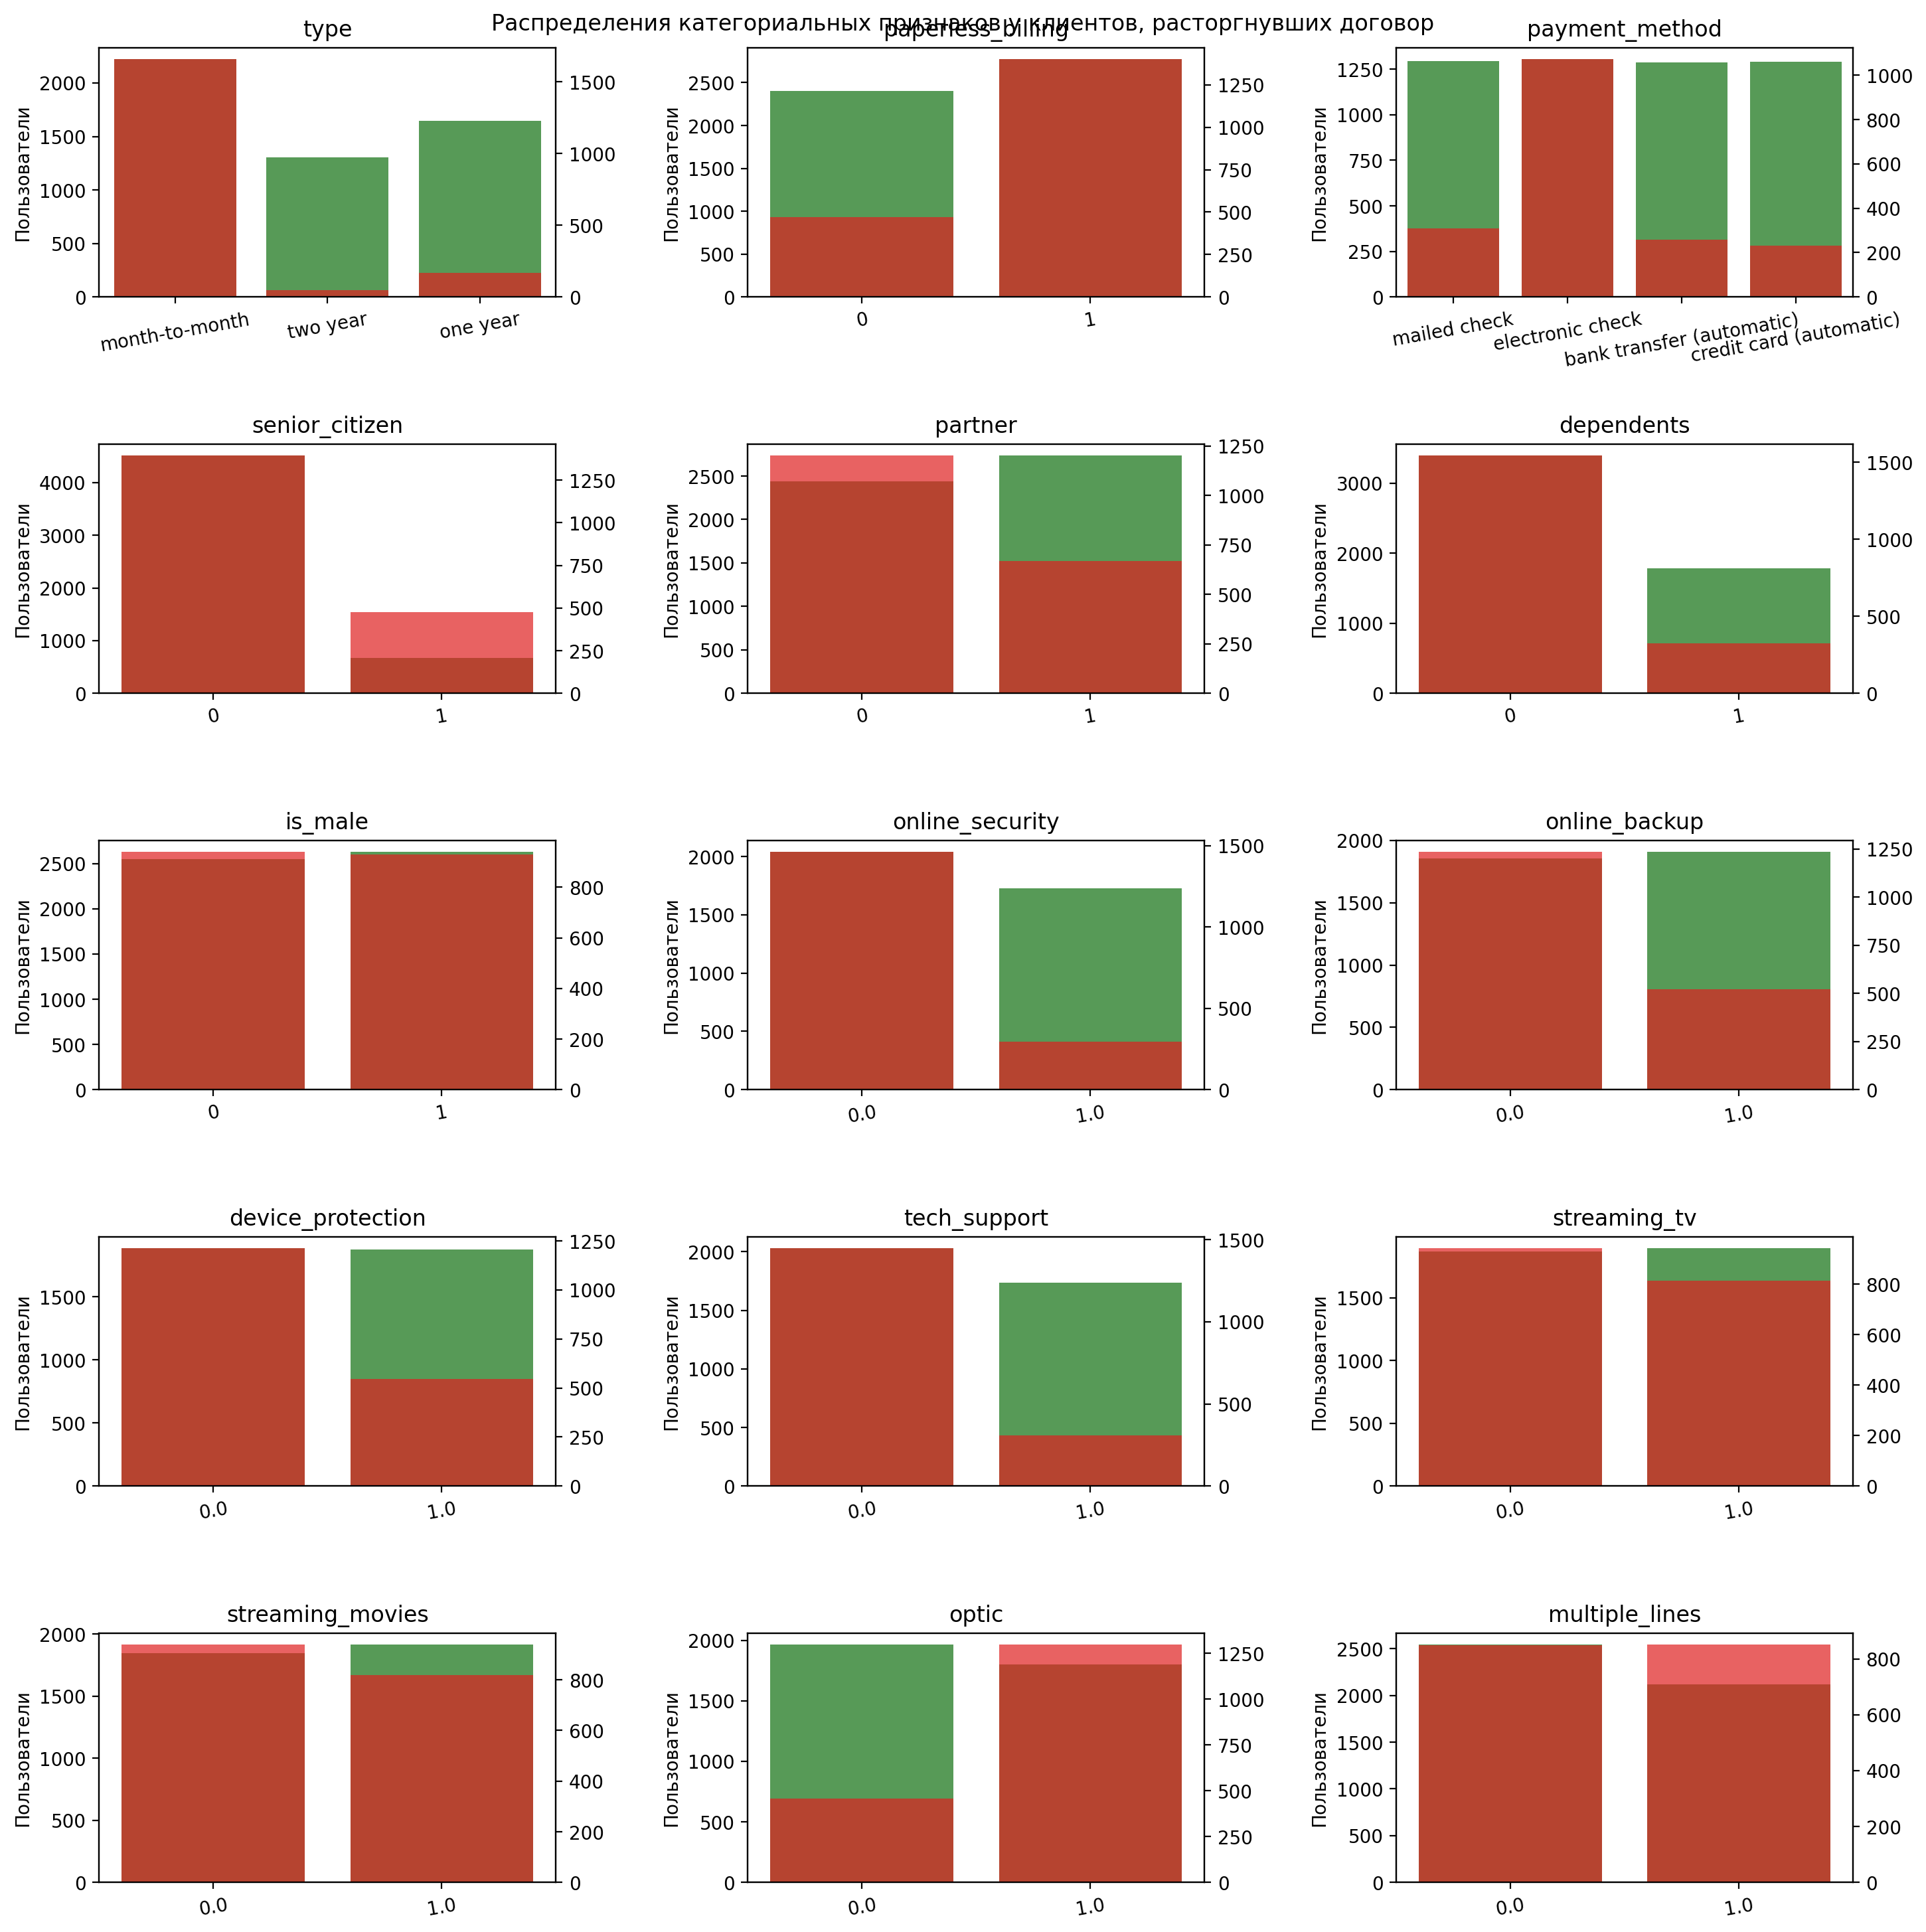

In [29]:
with Img('Распределения категориальных признаков у клиентов, расторгнувших договор', y=15, tight=True):
    active, exited = (data.query(f'exited == {i}') for i in range(2))
    for i, col in enumerate(cat_cols):
        Img.subplot(5, 3, i + 1, title=col, sx=False)
        # Живые будут зелёными
        sns.countplot(data=active, x=col, alpha=.7, color='green')
        plt.xticks(rotation=10)
        plt.xlabel(None)
        plt.ylabel('Пользователи')
        # Ушедшие будут красными. Также сделаем двойную ось Y, чтобы выровнять масштабы графиков по вертикали.
        sns.countplot(data=exited, x=col, alpha=.7, color='red', ax=plt.gca().twinx())
        plt.ylabel(None)

У нас получилось большое количество диаграмм, которые показывают соотношение тех или иных признаков у клиентов, которые расторгли с нами договор, и "живых" клиентов.
#### Как интерпретировать эти диаграммы?
***Наличие розовых областей на диаграммах обозначает повышенную степень риска для значений каждого признака. Наличие зелёных областей говорит о пониженной степени риска.***
#### Что мы увидели?
- Основная тенденция - наличие дополнительных услуг в основном положительно влияет на удержание клиентов.
- Наличие иждивенцев и партнёра тоже скорее помогает сохранять стабильность.
- Интересная ситуация с платежами:
    - Ежемесячные платежи - самая рискованная категория, вероятно, по той причине, что договор нет смысла расторгать на половине его срока действия, если мы говорим о годовой и двухгодичной подписках.
    - Безналичный расчёт более рискованный: возможно, что это связано с возрастом людей, которые пользуются современными платёжными системами. Сюда же относится электронный платёж. Остальные типы платежа легче тянут деньги с клиентов в силу принципов своей работы. Автоматические платежи для этого подходят отлично.
- Пол не имеет значения: баланс полов в обоих классах примерно одинаковый.
- Пенсионный возраст вряд ли может сказать нам кроме того, какой демографический состав нашей выборки. Возможно, что больше пенсионеров расторгают договор по причине своей смерти. Есть ли смысл предлагать услуги пенсионерам? Возможно, хотя это и может быть неэтично.

### Вывод из анализа
- Мы посмотрели на то, какие распределения признаков характерны для двух классов, которые мы собираемся предсказывать нашей моделью.
- Бегло оценили связь того или иного признака с уходом клиента с помощью визуализации.
- Сгенерировали некоторое количество идей по дальнейшей работе с признаками.

---

## 3. Обучение модели
Прежде, чем обучать модели, нам предстоит поработать над данными и привести их в подходящий вид. Посмотрим на наш датасет.

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   int64         
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   duration_days      7043 non-null   int64         
 9   exited             7043 non-null   int64         
 10  senior_citizen     7043 non-null   int64         
 11  partner            7043 non-null   int64         
 12  dependents         7043 non-null   int64         
 13  is_male            7043 non-null   int64         
 14  online_s

Столбцы с датами мы удалим, как и собирались. Это утечка данных, указывающая на конкретных клиентов. Заодно удалим id.

In [31]:
# Всё, кроме дат и id
data = data.select_dtypes(exclude='datetime').drop('customer_id', axis=1)

Пропуски в столбцах с услугами заполним нулями: если пользователь отсутствовал в таблице с услугами, логично думать, что он ими не пользовался. Иначе мы бы об этом знали.

In [32]:
# Все пропуски заполним нулями
data = data.fillna(0)

In [33]:
# Проверяем результат
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   int64  
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   duration_days      7043 non-null   int64  
 6   exited             7043 non-null   int64  
 7   senior_citizen     7043 non-null   int64  
 8   partner            7043 non-null   int64  
 9   dependents         7043 non-null   int64  
 10  is_male            7043 non-null   int64  
 11  online_security    7043 non-null   float64
 12  online_backup      7043 non-null   float64
 13  device_protection  7043 non-null   float64
 14  tech_support       7043 non-null   float64
 15  streaming_tv       7043 non-null   float64
 16  streaming_movies   7043 

Теперь нам потребуется преобразовать категориальные переменные в числовой вид.

### 3.1. Кодирование признаков
Попробуем два вида кодирования и в дальнейшем узнаем, какое из них дало лучший результат.

In [34]:
from sklearn.preprocessing import LabelEncoder

In [35]:
# Отбросим для каждого признака первое значение
cats_onehot = pd.get_dummies(data.select_dtypes('object'))
cats_onehot.head(3)

,type_month-to-month,type_one year,type_two year,payment_method_bank transfer (automatic),payment_method_credit card (automatic),payment_method_electronic check,payment_method_mailed check
0,1,0,0,0,0,1,0
1,0,1,0,0,0,0,1
2,1,0,0,0,0,0,1


In [36]:
# Закодируем каждый столбец номерами категорий
cats_ordinal = data.select_dtypes('object').apply(LabelEncoder().fit_transform)
cats_ordinal.head(3)

,type,payment_method
0,0,2
1,1,3
2,0,3


Отлично. Теперь можно выбросить эти данные из таблицы и подмешивать разные виды кодирования по мере необходимости.

In [37]:
# Удалим object из столбцов
data = data.select_dtypes(exclude='object').join(cats_onehot)

На данном этапе этого достаточно, чтобы попробовать обучить несколько моделей и выбрать базовую.

In [38]:
data.head(3)

,paperless_billing,monthly_charges,total_charges,duration_days,exited,senior_citizen,partner,dependents,is_male,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,optic,multiple_lines,type_month-to-month,type_one year,type_two year,payment_method_bank transfer (automatic),payment_method_credit card (automatic),payment_method_electronic check,payment_method_mailed check
0,1,29.85,29.85,31,0,0,1,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,1,0
1,0,56.95,1889.50,1036,0,0,0,0,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1
2,1,53.85,108.15,61,1,0,0,0,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1


### 3.2. Обучение базовой модели
Напишем пайплайн, который будем запускать с разными моделями. Нас интересуют ROC-AUC, точность и полнота ответов модели (полнота хороша в нашем случае, потому что у нас нет ограничений по количеству юзеров, которых нам нужно отобрать, и мы можем не сильно переживать за то, что выберем неверного юзера).

Подготовим функции для кросс-валидации нескольких моделей сразу.

In [39]:
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score
from sklearn.model_selection import train_test_split, cross_validate
import re


def cv_pipeline(model, data, target='exited'):
    """Пайплайн для кросс-валидации модели."""
    def xy_split(data):
        """Деление данных на предикторы и целевой признак."""
        return data.drop(target, axis=1), data[target]
    
    # Возвращаем результаты кросс-валидации
    return cross_validate(model, *xy_split(data), scoring=['roc_auc', 'accuracy', 'recall', 'precision', 'f1']), model

def batch_train(*models, data, name_pattern=re.compile(r'[A-Z]\w*')):
    def model_name(model):
        """Возвращает имя модели sklearn."""
        name = str(model)
        try:
            return re.findall(name_pattern, str(model))[0]
        except:
            return name
    
    # Возвращаем составной датафрейм из кросс-валидаций всех моделей и столбец с названием моделей
    return pd.concat(pd.DataFrame(data=cv_pipeline(model, data)[0]).assign(model=model_name(model))
                     for model in models).drop(['fit_time', 'score_time'], axis=1).reset_index(drop=True)

Попробуем обучить как можно больше моделей и посмотрим, что работает лучше всего.

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

Создадим список из моделей.

In [41]:
random_state = 42

models = (LogisticRegression(class_weight='balanced', random_state=random_state),
          BernoulliNB(),
          DecisionTreeClassifier(class_weight='balanced', random_state=random_state),
          RandomForestClassifier(class_weight='balanced', random_state=random_state),
          XGBClassifier(verbosity=0, random_state=random_state),
          CatBoostClassifier(verbose=0, random_state=random_state),
          LGBMClassifier(verbose=0, random_state=random_state))

Получим таблицу с данными о каждой итерации кросс-валидации для каждой модели.

In [42]:
baseline_scores = batch_train(*models, data=data)
baseline_scores

,test_roc_auc,test_accuracy,test_recall,test_precision,test_f1,model
0,0.852014,0.745209,0.836898,0.512275,0.635533,LogisticRegression
1,0.848531,0.749468,0.810160,0.517949,0.631908,LogisticRegression
2,0.828142,0.735983,0.796791,0.501684,0.615702,LogisticRegression
3,0.833648,0.733665,0.788204,0.498305,0.610592,LogisticRegression
4,0.831954,0.754972,0.764706,0.526703,0.623773,LogisticRegression
5,0.836820,0.763662,0.676471,0.544086,0.603099,BernoulliNB
6,0.832921,0.777857,0.700535,0.565875,0.626045,BernoulliNB
7,0.808378,0.756565,0.663102,0.533333,0.591180,BernoulliNB
8,0.812225,0.769176,0.675603,0.552632,0.607961,BernoulliNB
9,0.812378,0.758523,0.676471,0.536017,0.598109,BernoulliNB


In [43]:
# На всякий случай запишем в базу данных
sql.register_table('baseline', baseline_scores)

Отлично: у нас получились данные о качестве всех наших моделей. Можно их проанализировать.

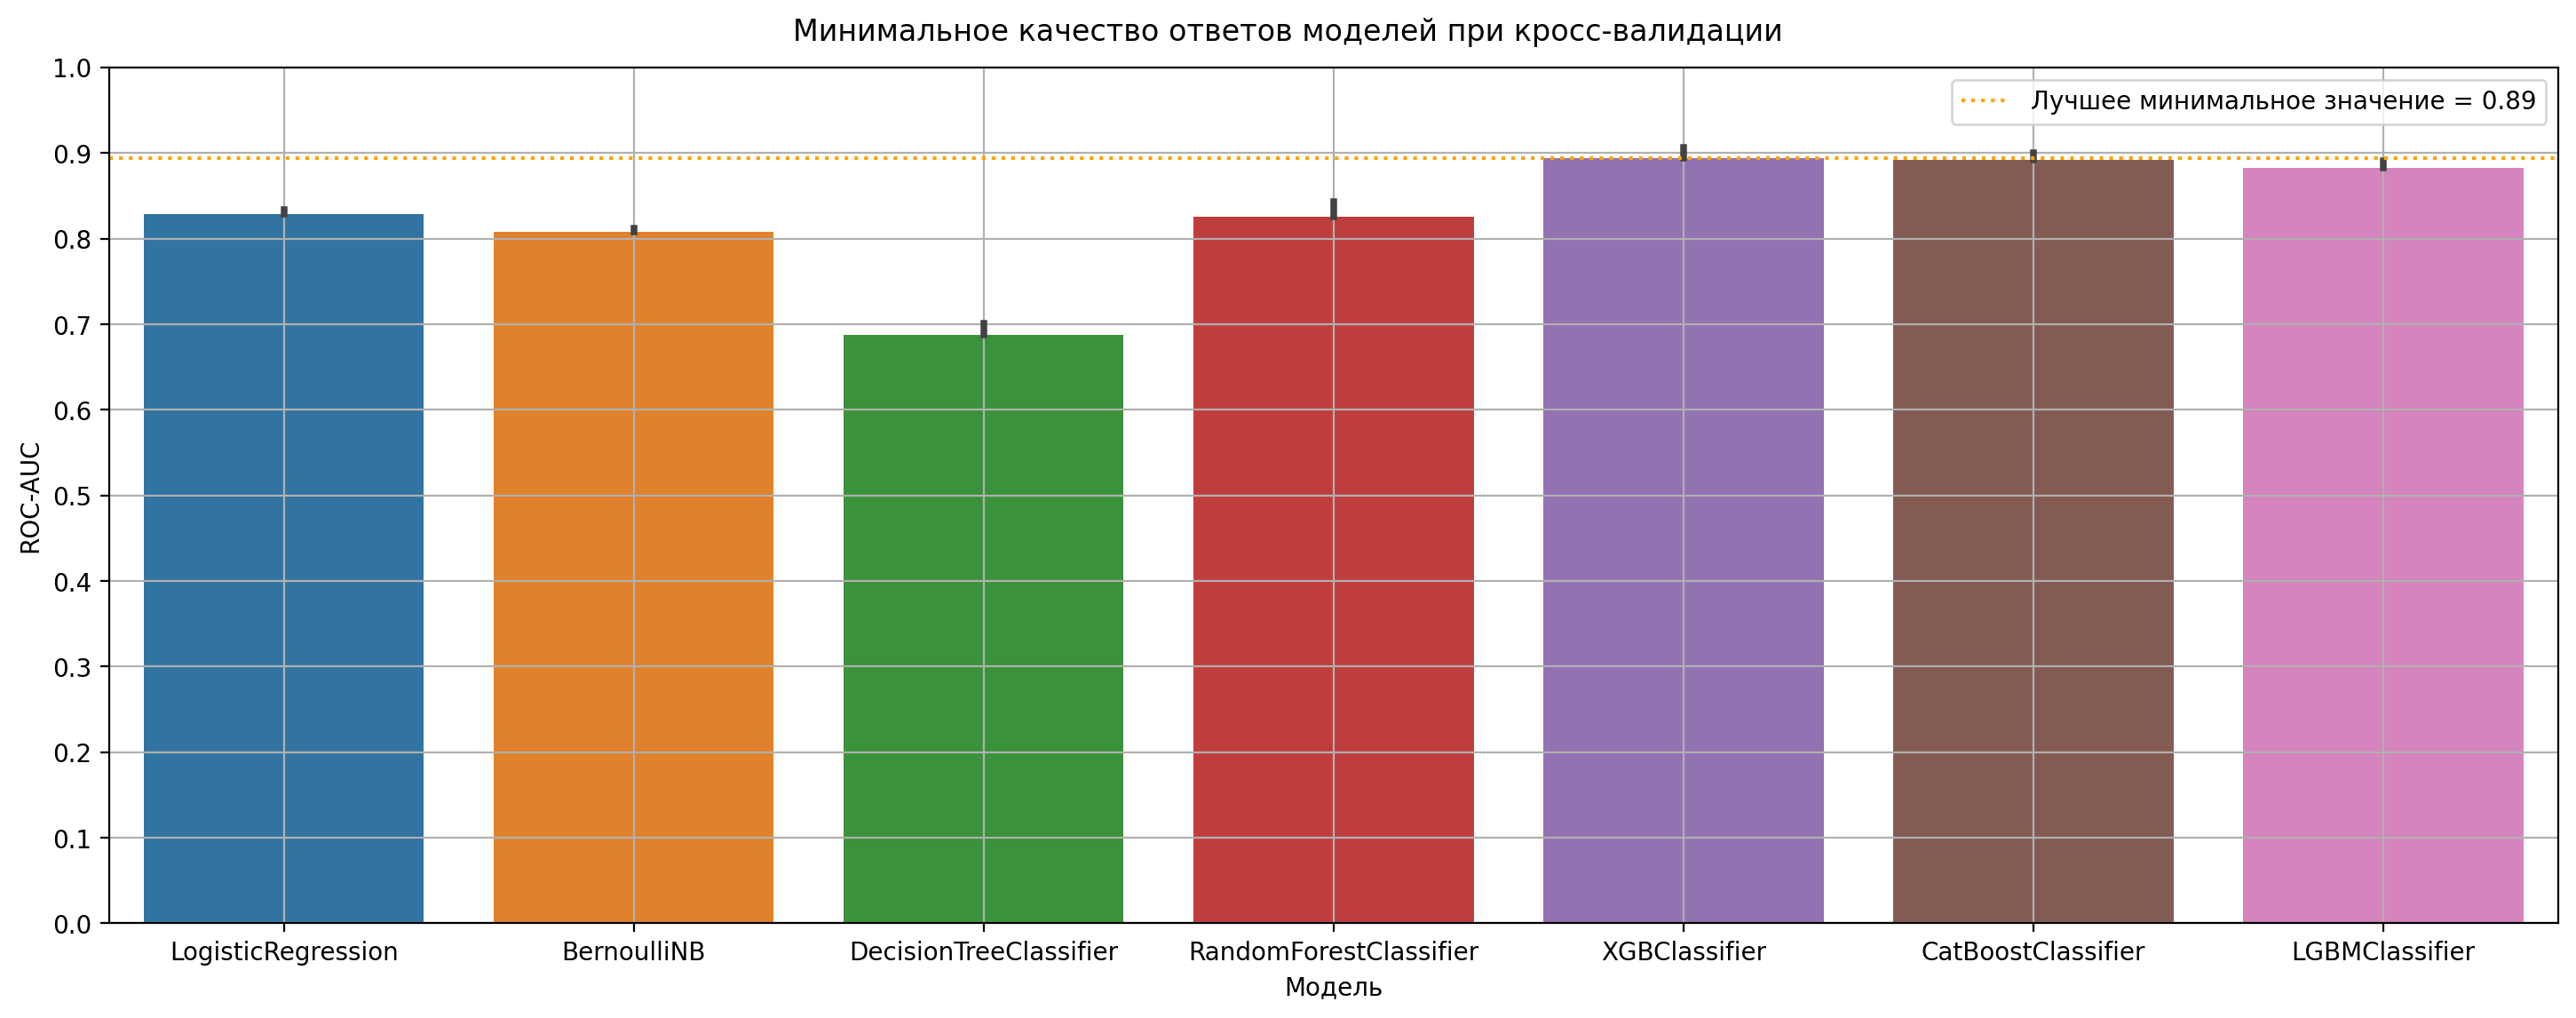

In [44]:
with Img('Минимальное качество ответов моделей при кросс-валидации', y=6, tight=True, grid=True, legend='a'):
    sns.barplot(data=baseline_scores, y='test_roc_auc', x='model', estimator=min)
    # Возьмём лучшее минимальное значение
    best_minimum = baseline_scores.groupby('model').test_roc_auc.min().max()
    plt.axhline(best_minimum, label=f'Лучшее минимальное значение = {best_minimum:.2}', c='orange', ls=':')
    Img.labels('Модель', 'ROC-AUC')
    plt.yticks(np.arange(0, 1.1, .1))

- Наиболее высокие результаты показывают модели бустинга. Впрочем, это происходит почти всегда.
- Дерево не работает хорошо из коробки. Возможно, что у него получилось бы, если бы мы оптимизировали его гиперпараметры.
- Логистическая регрессия и случайный лес дают примерно одинаковые результаты. Учитывая скорость регрессии, мы бы предпочли её.
- Байесовский классификатор находится на границе между зачётом и незачётом, но показывает себя достойно и вполне оправдывает наши ожидания.

Пока что примем за базовую модель `XGBoost` и её худший результат - **ROC-AUC = *0.89***. Далее будем экспериментировать с признаками и постараемся подобрать лучшие.

In [45]:
# Обозначим базовую модель
model = XGBClassifier(verbose=0)

### 3.3. Отбор признаков
У нас есть некоторые гипотезы, связанные с полезностью некоторых признаков: мы будем их проверять и отмечать разницу в минимальной ROC-AUC. Если у нас получится сделать хотя бы *0.9*, будет просто отлично.

In [46]:
# Вспомним столбцы
data.columns

Index(['paperless_billing', 'monthly_charges', 'total_charges',
       'duration_days', 'exited', 'senior_citizen', 'partner', 'dependents',
       'is_male', 'online_security', 'online_backup', 'device_protection',
       'tech_support', 'streaming_tv', 'streaming_movies', 'optic',
       'multiple_lines', 'type_month-to-month', 'type_one year',
       'type_two year', 'payment_method_bank transfer (automatic)',
       'payment_method_credit card (automatic)',
       'payment_method_electronic check', 'payment_method_mailed check'],
      dtype='object')

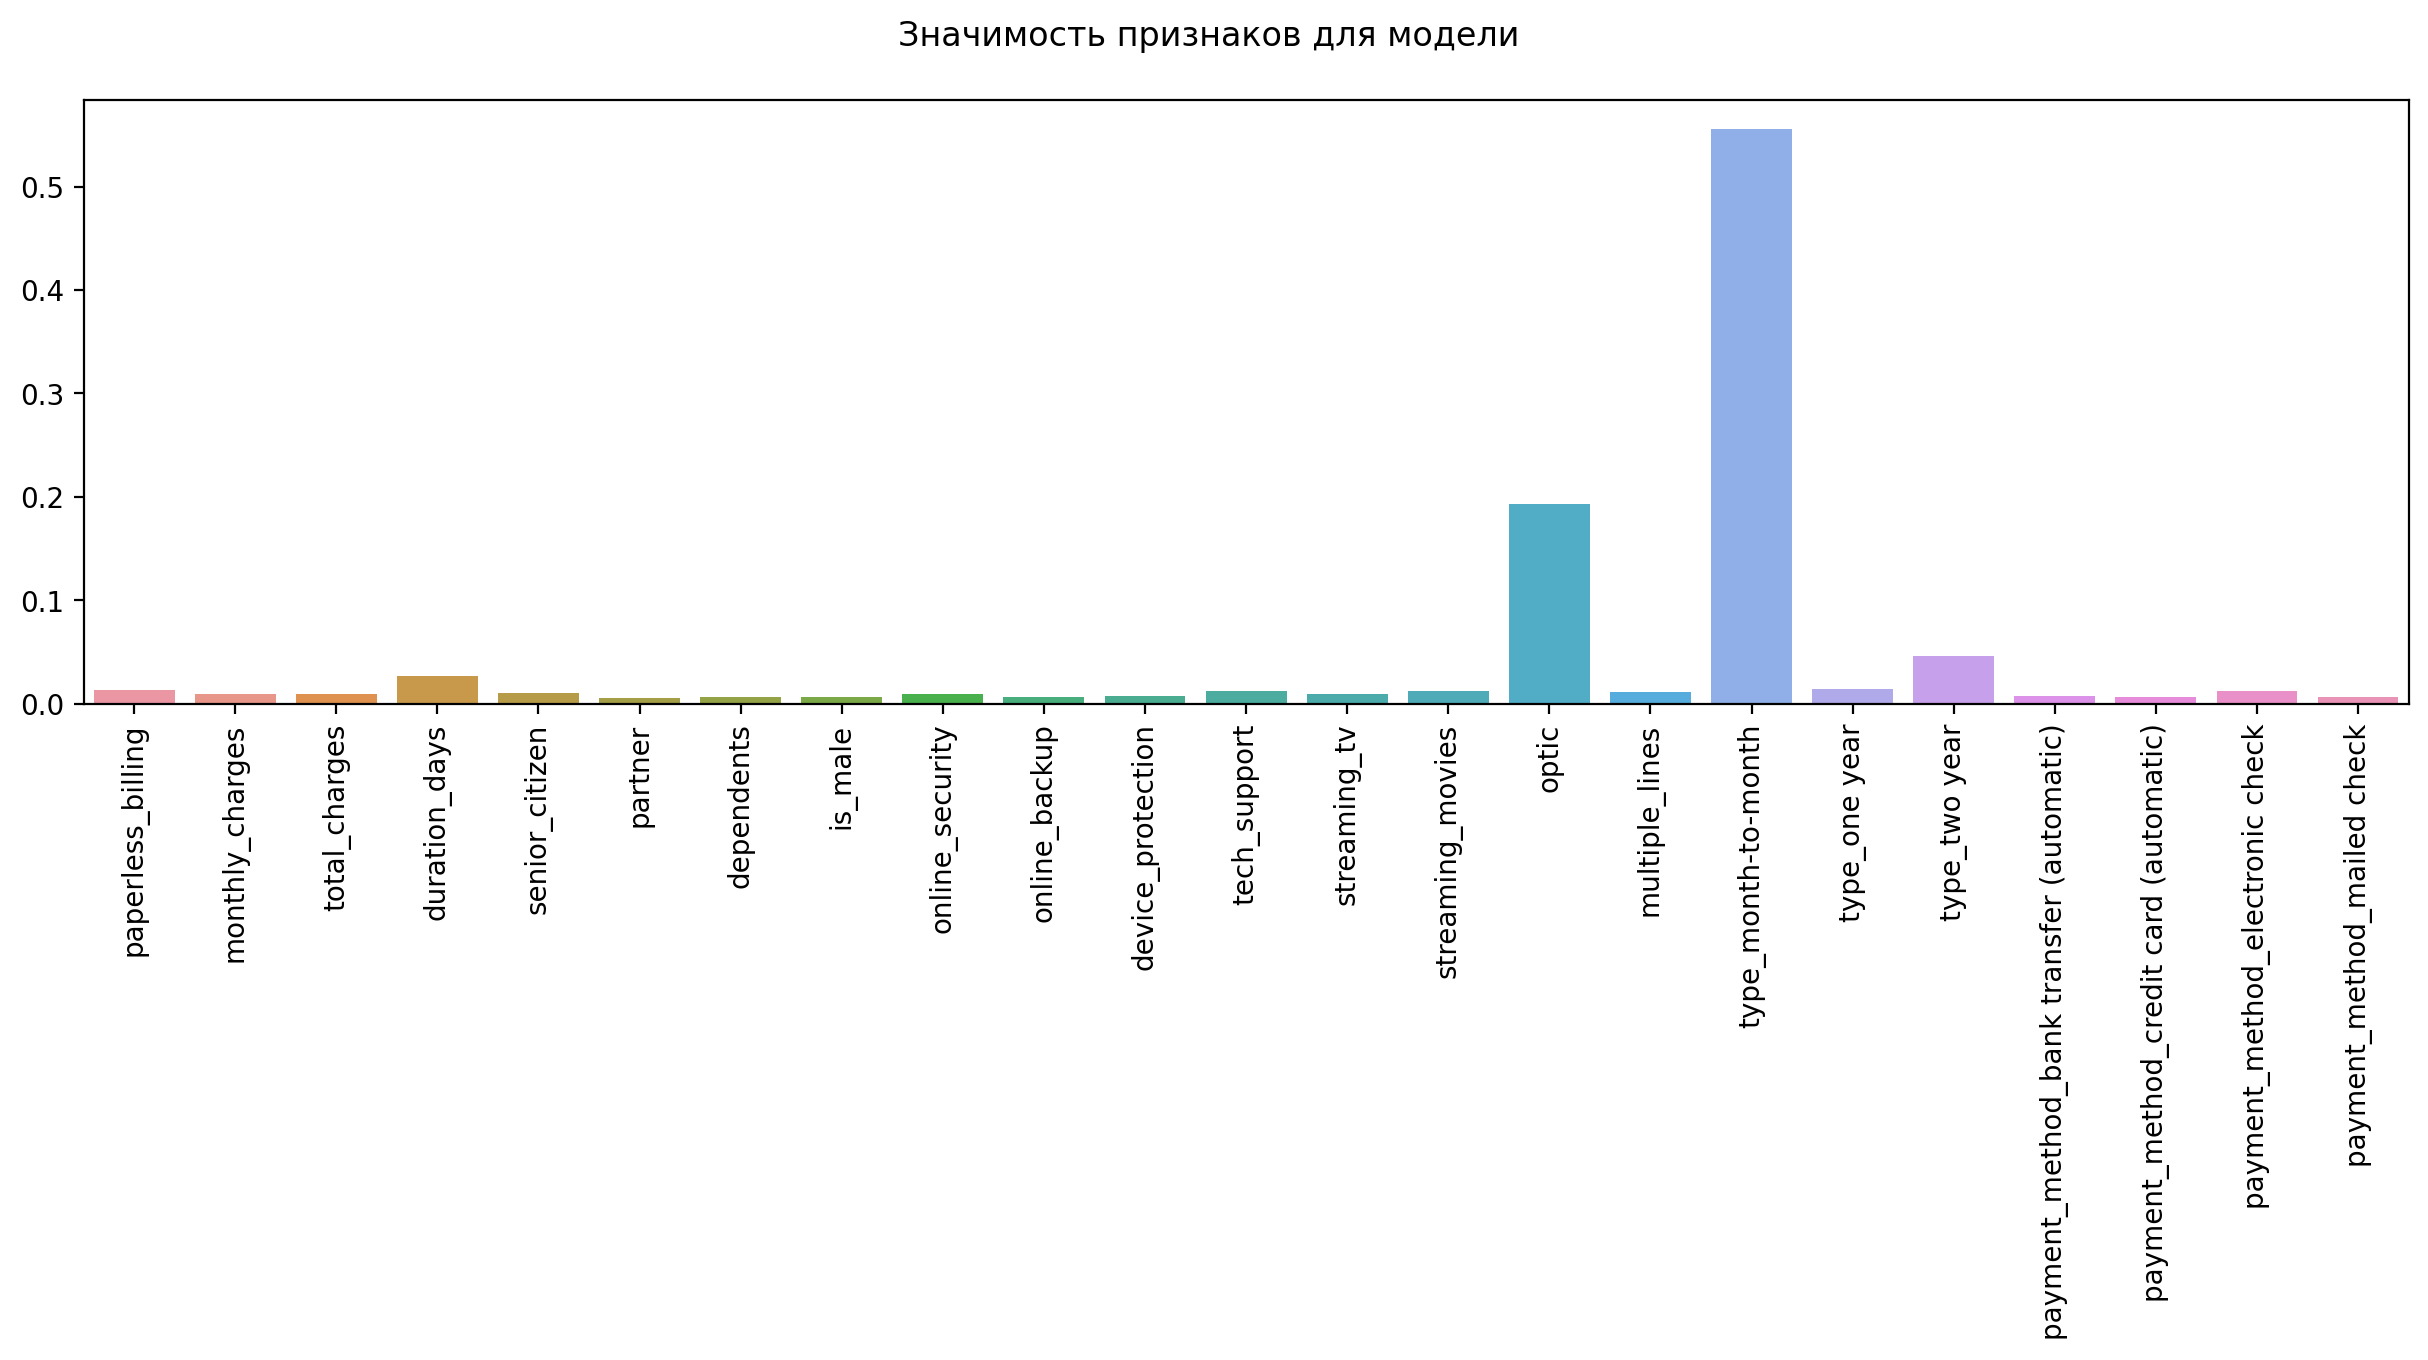

In [47]:
with Img('Значимость признаков для модели'):
    sns.barplot(y=model.fit(data.drop('exited', axis=1), data.exited).feature_importances_, x=data.drop('exited', axis=1).columns)
    plt.xticks(rotation=90)

- Видим, насколько сильно модель реагирует на помесячную подписку и оптоволокно. Возникает ощущение, что эти признаки тянут на себя всё внимание модели. Интересно, что будет, если мы попробуем их удалить.
- Остальные признаки важны в значительно меньшей степени.

Обозначим функцию, которая поможет нам в одну строку экспериментировать с признаками и находить минимальную ROC-AUC модели с помощью bootstrap. Мы будем мыслить именно минимумами, потому что лучше - это хорошо, а хуже - нежелательно.

In [48]:
from functools import partial


def experiment(data, model):
    """Находит приблизительную нижнюю границу roc_auc модели с заданными данными."""
    np.random.seed(42)
    roc_auc = cv_pipeline(model, data)[0]['test_roc_auc']
    # Возвращает среднее минимальное значение из 5000 итераций
    return np.mean([np.min(np.random.choice(roc_auc, 3))
                    for i in range(5000)])

feature_experiment = partial(experiment, model=model)

In [49]:
# Датасет для экспериментов
df = data.copy()

In [50]:
# Базовый средний минимум
feature_experiment(df)

0.8977711997388553

#### Кодирования категориальных признаков номерами
У нас есть столбцы, закодированные LabelEncoder. Воспользуемся ими вместо One-Hot.

In [51]:
feature_experiment(df.iloc[:, :-7].join(cats_ordinal))

0.8969149769402629

Сложно сказать, что качество сильно ухудшилось, но мы будем придерживаться One-Hot.

#### Удаление столбцов, которые выглядят связанными
У нас есть столбцы с длительностью контракта и суммарными платежами. Что, если удалить один из них?

In [52]:
# Удалим суммарные платежи
feature_experiment(df.drop('total_charges', axis=1))

0.9035052823621991

In [53]:
# Удалим время жизни
feature_experiment(df.drop('duration_days', axis=1))

0.8099390768033385

Время жизни критично важно, а вот удаление суммарных платежей может быть оправдано. Наша догадка из EDA подтвердилась.

In [54]:
# Закрепим результат
df = df.drop('total_charges', axis=1)

#### Что, если важные признаки мешают всему остальному?
Оптоволокно и месячная подписка - сильные признаки. Попробуем их убрать и посмотрим, что будет.

In [55]:
# Удалим подписку
feature_experiment(df.drop('type_month-to-month', axis=1))

0.9044109267788588

Интересно, но качество слегка выросло.

In [56]:
feature_experiment(df.drop('optic', axis=1))

0.9040250220480095

Качество тоже выше. Что, если совместить?

In [57]:
feature_experiment(df.drop(['optic', 'type_month-to-month'], axis=1))

0.9058067787570541

Удивительно: удаление значимых признаков привело к улучшению предсказаний! Правда, если мы удалим часть One-Hot признаков, а часть оставим, то вряд ли в этом будет большой смысл, ведь мы потеряем часть информации.

#### Кластеризация пользователей по ежемесячному платежу
У нас была идея сделать из количественного признака с помесячным платежом категориальный с помощью кластеризации.

Посмотрим на распределение.

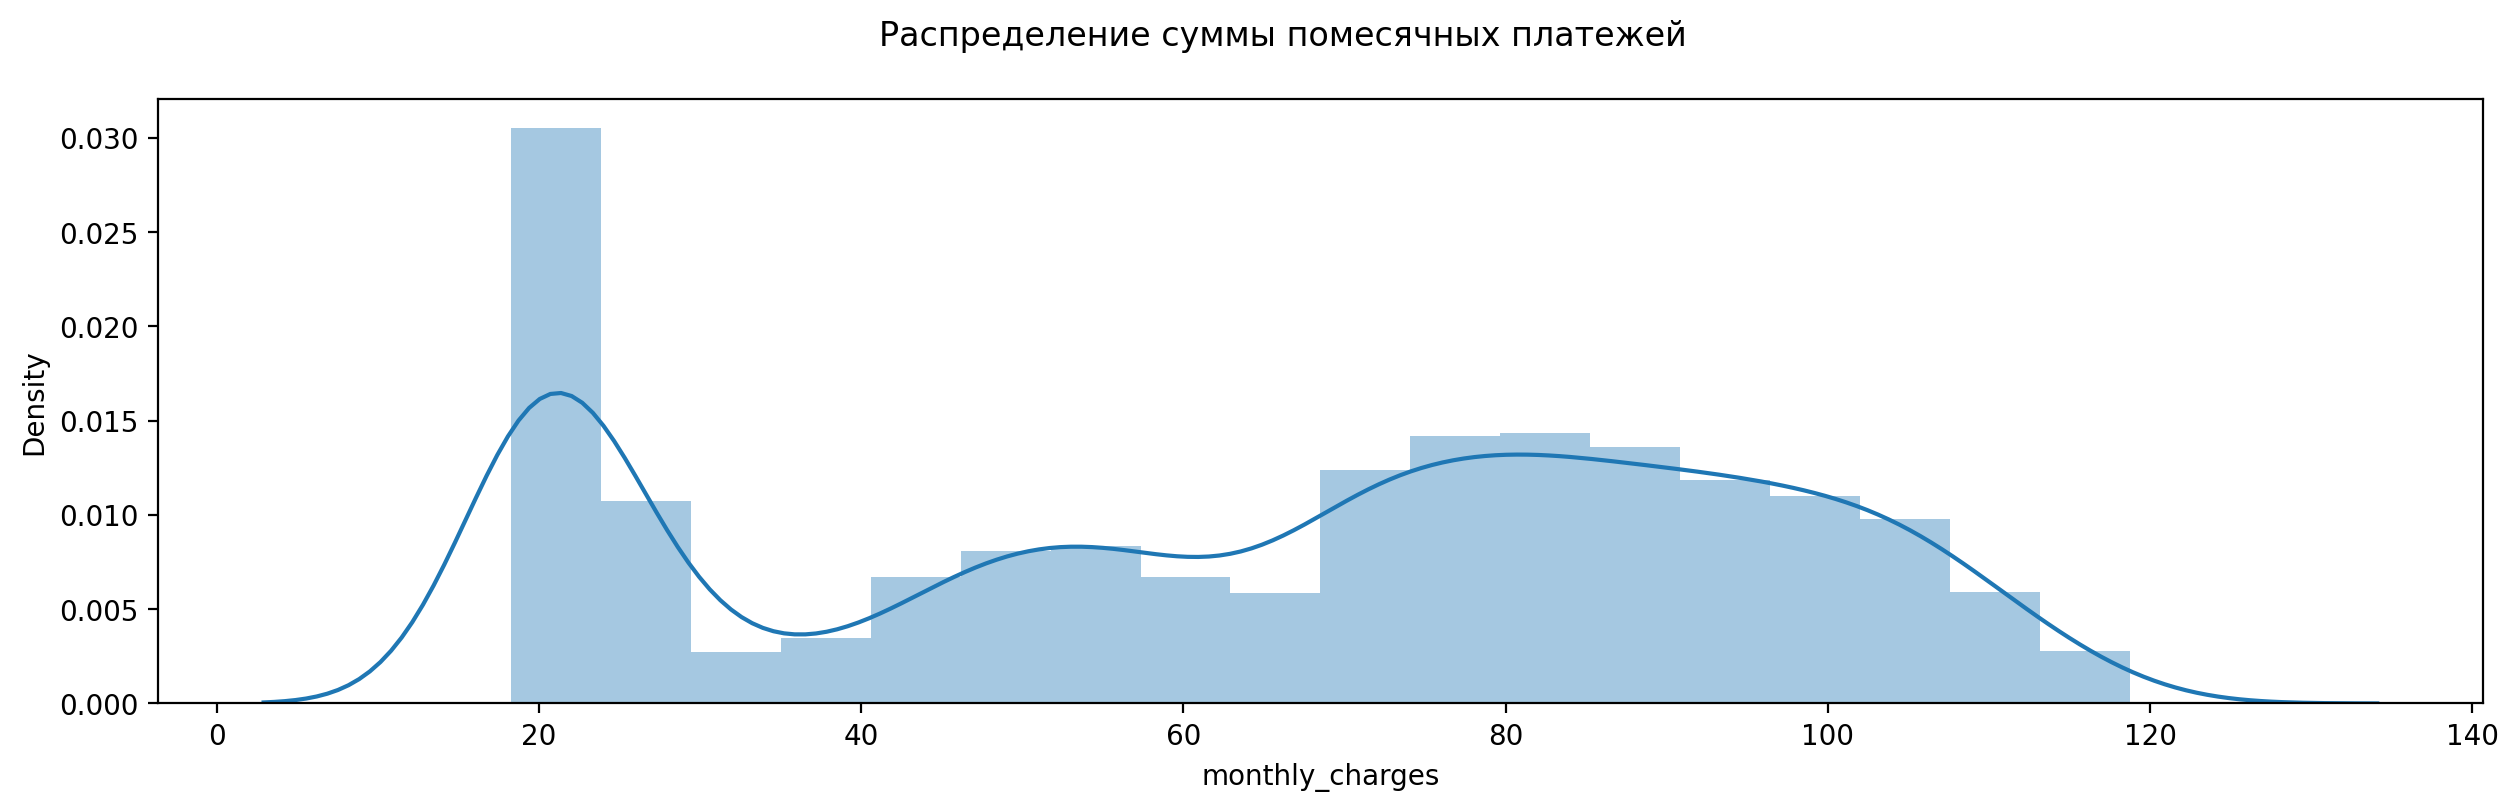

In [58]:
with Img('Распределение суммы помесячных платежей'):
    sns.distplot(data.monthly_charges)

- Визуально выделяются 3 пика: 20, 50 и 80. Можно попробовать принять эти значения за центроиды.

In [59]:
from sklearn.cluster import KMeans

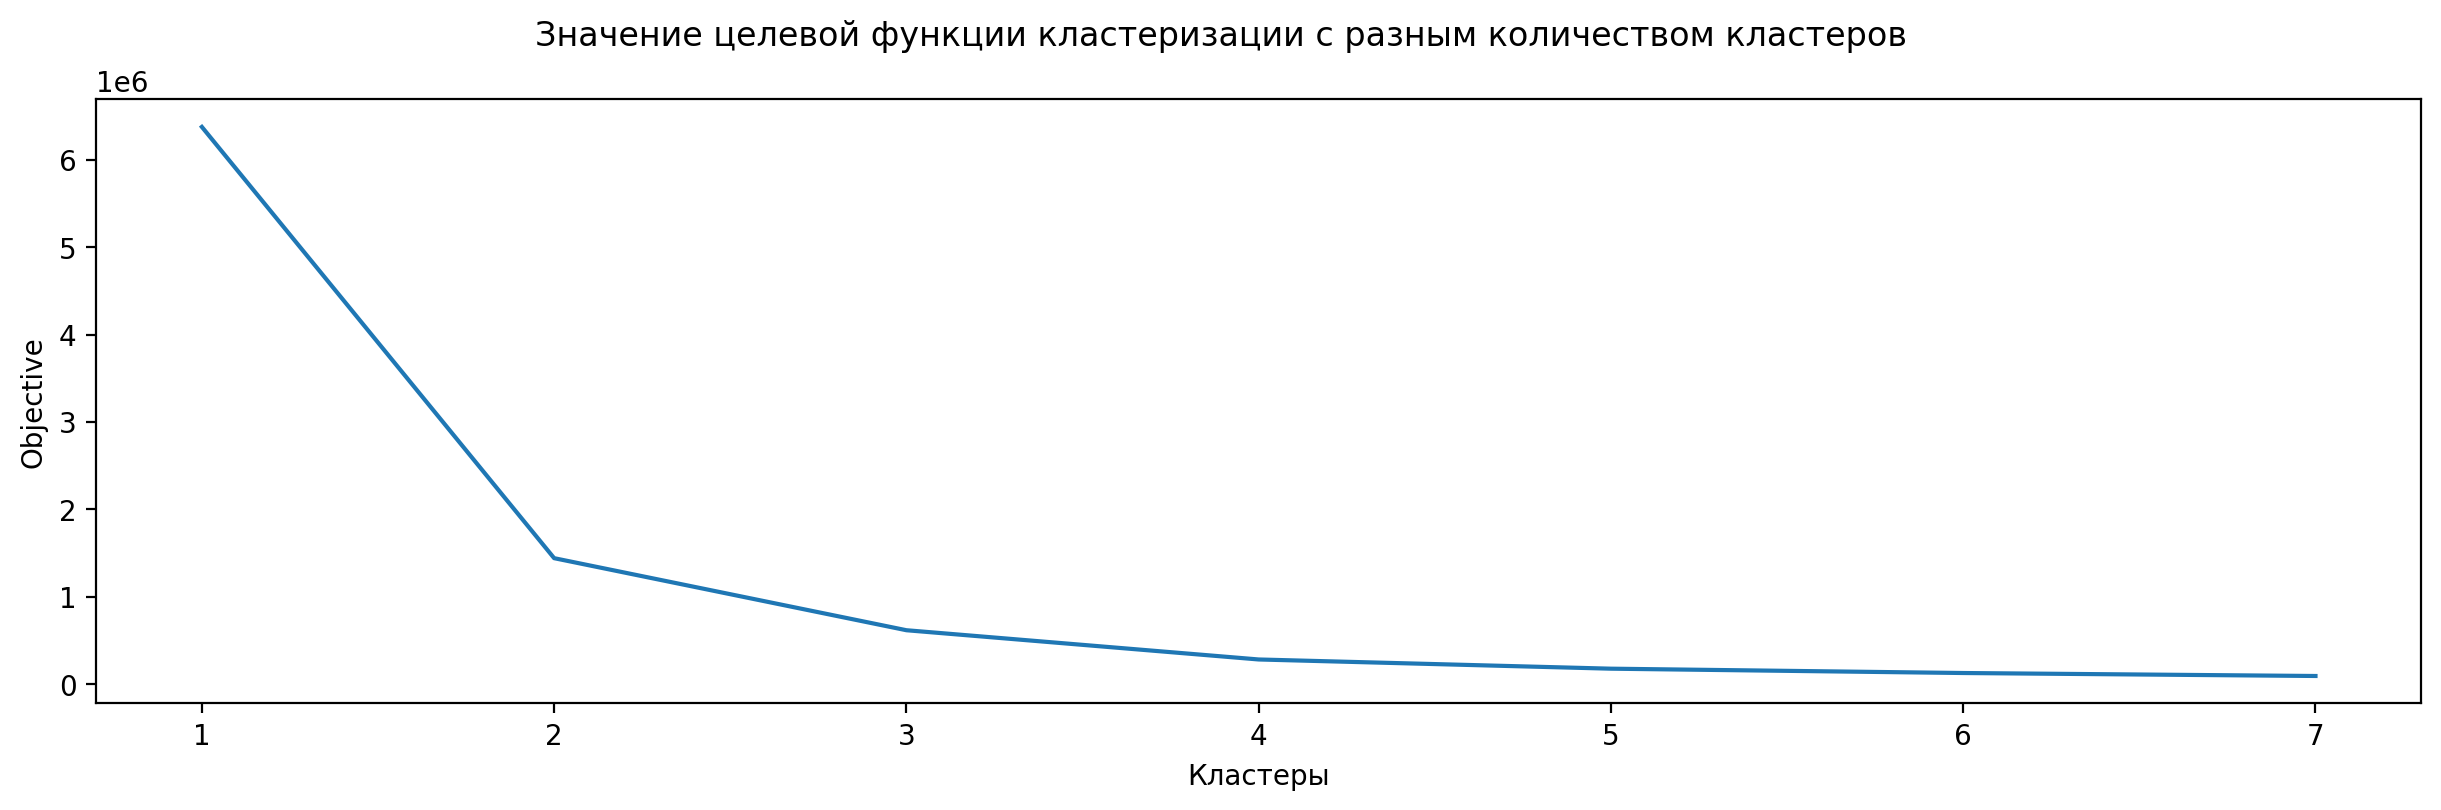

In [60]:
with Img('Значение целевой функции кластеризации с разным количеством кластеров'):
    sns.lineplot(x=range(1, 8),
                 y=(KMeans(k, random_state=42).fit(data.monthly_charges.values.reshape(-1, 1)).inertia_
                    for k in range(1, 8)))
    Img.labels('Кластеры', 'Objective')

- Для нас оптимальным количеством кластеров будет 3, максимум 4, потому что дальше целевая функция меняется минимально, и K-means начинает реагировать на частные случаи.

Попробуем сгенерировать кластеры и посмотрим, есть ли от этого польза для классификации. Не забудем отбросить исходный столбец с платежами: он будет нам мешать.

In [61]:
print('initial:', feature_experiment(df))
for k in range(2, 7):
    print(f'clusters: {k}. roc-auc =', feature_experiment(df.assign(cluster=KMeans(k, random_state=42).fit_predict(df.monthly_charges.values.reshape(-1, 1)))
                                                          .drop('monthly_charges', axis=1)))

initial: 0.9035052823621991
clusters: 2. roc-auc = 0.918479374203795
clusters: 3. roc-auc = 0.920378234114253
clusters: 4. roc-auc = 0.9202734149524233
clusters: 5. roc-auc = 0.9192800760909017
clusters: 6. roc-auc = 0.9198551526481026


- Получилось любопытно. Мы уверенно выигрываем больше, чем десятую процента, если используем кластеры вместо количественных платежей. Такой признак стоит оставить.
- Интересно, что после 3 кластеров метрика пошла вниз, что соответствует нашему решению об оптимальном количестве кластеров.

Закрепим наш результат в датафрейме.

In [62]:
# Оставляем кластеры, удаляем помесячные платежи
df = df.assign(cluster=KMeans(3, random_state=42).fit_predict(df.monthly_charges.values.reshape(-1, 1))).drop('monthly_charges', axis=1)

In [63]:
# Проверяем
feature_experiment(df)

0.920378234114253

У нас получился достойный датасет. Посмотрим на него.

In [64]:
df.head()

,paperless_billing,duration_days,exited,senior_citizen,partner,dependents,is_male,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,optic,multiple_lines,type_month-to-month,type_one year,type_two year,payment_method_bank transfer (automatic),payment_method_credit card (automatic),payment_method_electronic check,payment_method_mailed check,cluster
0,1,31,0,0,1,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,1,0,2
1,0,1036,0,0,0,0,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,0
2,1,61,1,0,0,0,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0
3,0,1371,0,0,0,0,1,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,1,0,1,0,0,0,2
4,1,61,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0,1,0,0


#### Удаление малозначимых признаков
Можно по очереди удалять признаки, которые имеют наименьшую значимость для модели.

In [65]:
from sklearn.feature_selection import SelectFromModel

In [66]:
def feature_knockout(model, data) -> dict:
    """Пайплайн для удаления малозначимых признаков по очереди."""
    results = {}
    # Поочерёдно убираем признаки
    for n in range(data.shape[1] - 1, 0, -1):
        np.random.seed(42)
        # Оставляем n наиболее значимых признаков
        X = pd.DataFrame(SelectFromModel(model, threshold=-np.inf, max_features=n).fit_transform(data.drop('exited', axis=1), data.exited))
        # Получаем распределение из 5 roc-auc кросс-валидацией
        roc_auc = cv_pipeline(model, X.assign(exited=data.exited))[0]['test_roc_auc']
        # Записываем bootstrap в словарь с ключом-количеством признаков
        results[n] = np.mean([np.min(np.random.choice(roc_auc, 3))
                              for i in range(5000)])
    return results

In [67]:
# Запишем эксперименты в переменную
knockout = feature_knockout(model, df)

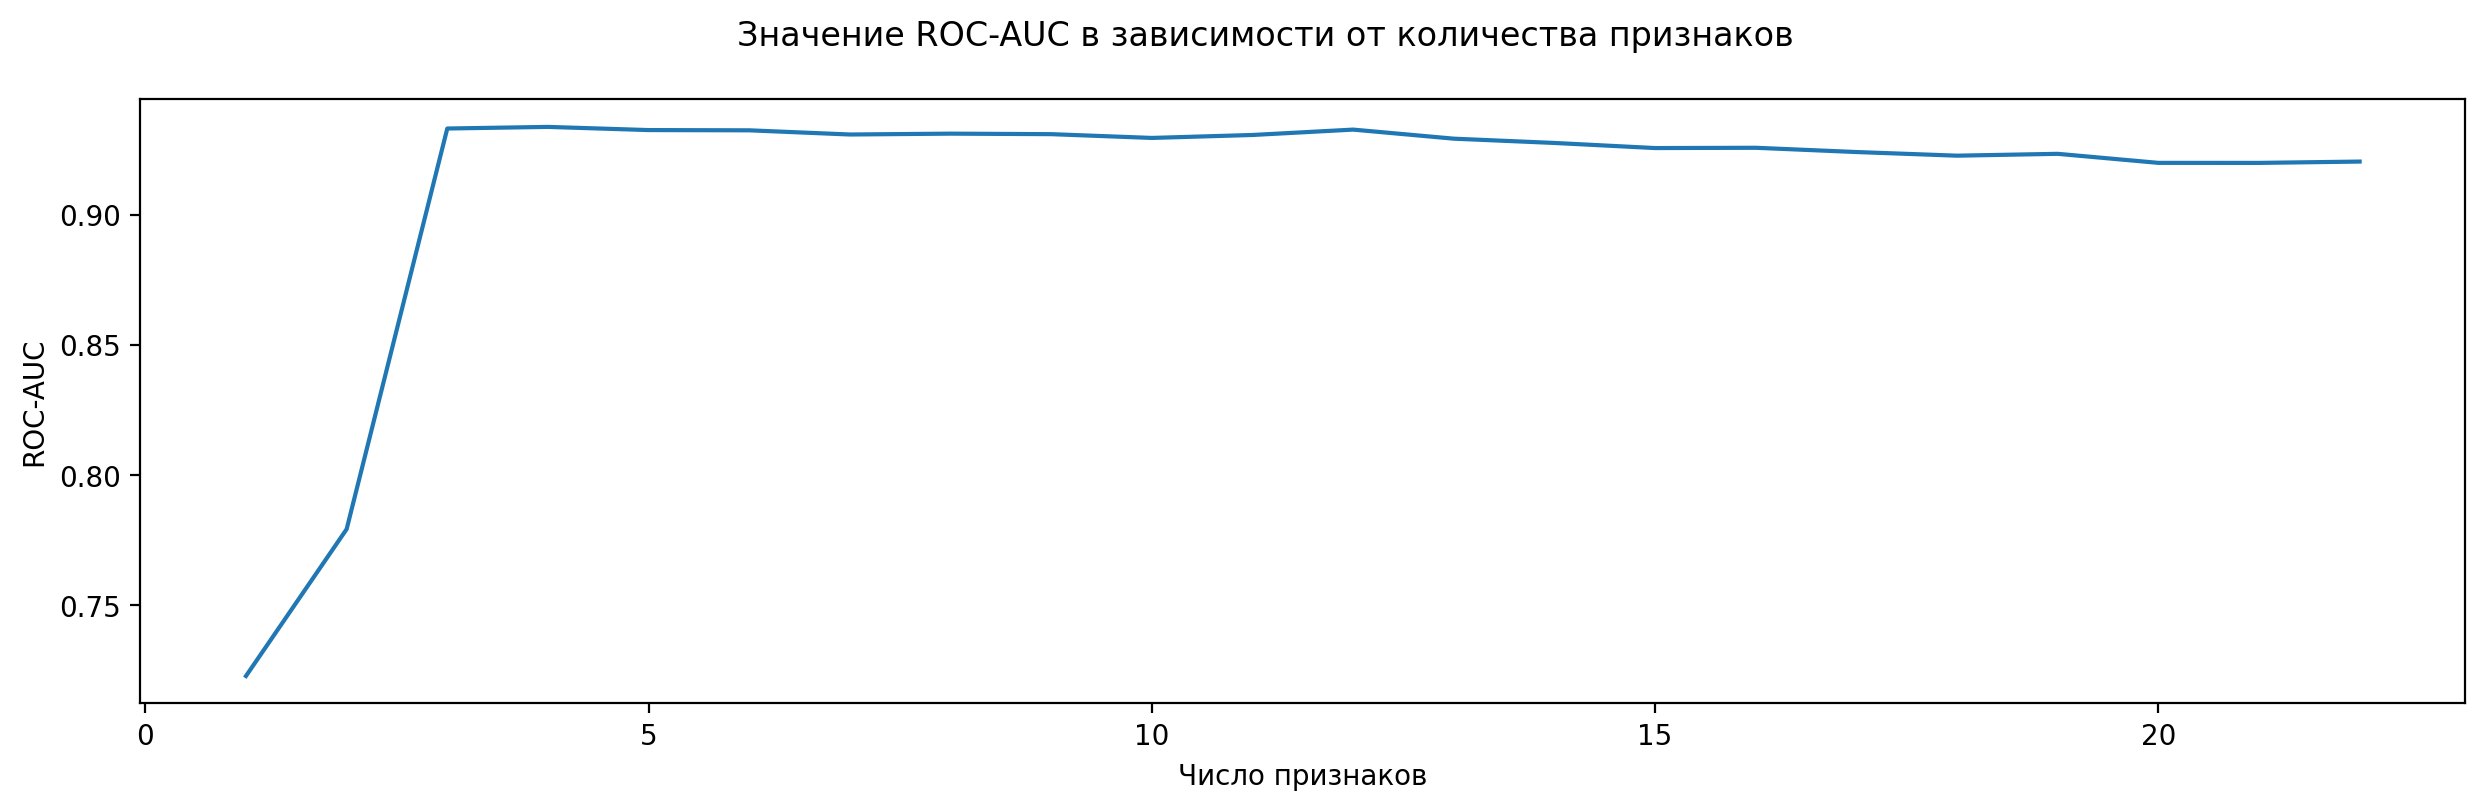

In [68]:
with Img('Значение ROC-AUC в зависимости от количества признаков'):
    sns.lineplot(data=knockout)
    Img.labels('Число признаков', 'ROC-AUC')

- Глядя на этот график, сложно сказать, сколько признаков лучше всего оставить: можно поступить практически как угодно. Важно не оставлять совсем мало признаков.
- В любом случае, мы уже получили отличное качество предсказаний, которое сложно испортить чем бы то ни было.

Посмотрим на лучшие значения ROC-AUC, которые у нас получились.

In [69]:
# Топ-10 результатов
pd.Series(knockout).sort_values(ascending=False).head(10)

4     0.933694
3     0.933075
12    0.932655
5     0.932475
6     0.932379
8     0.931102
9     0.930905
7     0.930773
11    0.930591
10    0.929457
dtype: float64

Возьмём за основу датасет с 12 признаками, чтобы не списывать со счетов огромное количество всего. После преобразования нам сложно будет понять, что это за признаки, потому что у нас потерялись названия столбцов.

In [70]:
# Создадим финальный датасет
data_final = pd.DataFrame(
    data=SelectFromModel(model, threshold=-np.inf, max_features=12).fit_transform(df.drop('exited', axis=1), df.exited)
).assign(exited=df.exited)

data_final.head()

,0,1,2,3,4,5,6,7,8,9,10,11,exited
0,1.0,31.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0
1,0.0,1036.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2,1.0,61.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
3,0.0,1371.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0
4,1.0,61.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1


Видим, что в признаки попала длительность контракта и кластеры, которые мы нашли.

In [71]:
# Сверим roc_auc
feature_experiment(data_final)

0.9326551990761592

### 3.4. Оптимизация гиперпараметров
Попробуем ещё немного улучшить качество модели, пробуя разные гиперпараметры. Мы не будем писать здесь весь эксперимент - только то, к чему мы пришли.

In [72]:
from sklearn.model_selection import GridSearchCV

In [73]:
# Посчитаем баланс классов, чтобы проверить его пользу как гиперпараметра
ones = data_final.exited.sum()
zeros = data_final.shape[0] - ones
balance = zeros / ones
print(zeros, ones, balance)

5174 1869 2.7683253076511503


In [74]:
# Подберём параметры
gs = GridSearchCV(XGBClassifier(random_state=42), param_grid={'max_depth': range(1, 8),
                                                              'learning_rate': np.arange(.3, 1.4, .1),
                                                              'scale_pos_weight': [1, balance]},
                  cv=5, scoring='roc_auc')

In [75]:
%%time
gs.fit(data_final.drop('exited', axis=1), data.exited)

CPU times: user 11min 57s, sys: 7.66 s, total: 12min 5s
Wall time: 1min 36s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=42,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, v

Параметры подобраны, посмотрим на них.

In [76]:
gs.best_params_

{'learning_rate': 1.2000000000000004,
 'max_depth': 2,
 'scale_pos_weight': 2.7683253076511503}

- По умолчанию XGBoost использует деревья с глубиной = *6*. У нас - *3*.
- Скорость обучения также выше, чем у базовой модели = *0.3*.
- Наша балансировка классов оказалась полезной.

Интересно, какое значение метрики продемонстрирует наша новая модель.

In [77]:
# Сохраним финальную модель в переменную
model_final = XGBClassifier(**gs.best_estimator_.get_params())

# Проведём эксперимент с финальными вводными
experiment(data_final, model_final)

0.9386720275509371

Нам удалось поднять нижнюю границу ROC-AUC ещё на *0.6%*. Нарисуем финальную диаграмму с остальными метриками и завершим наш проект.

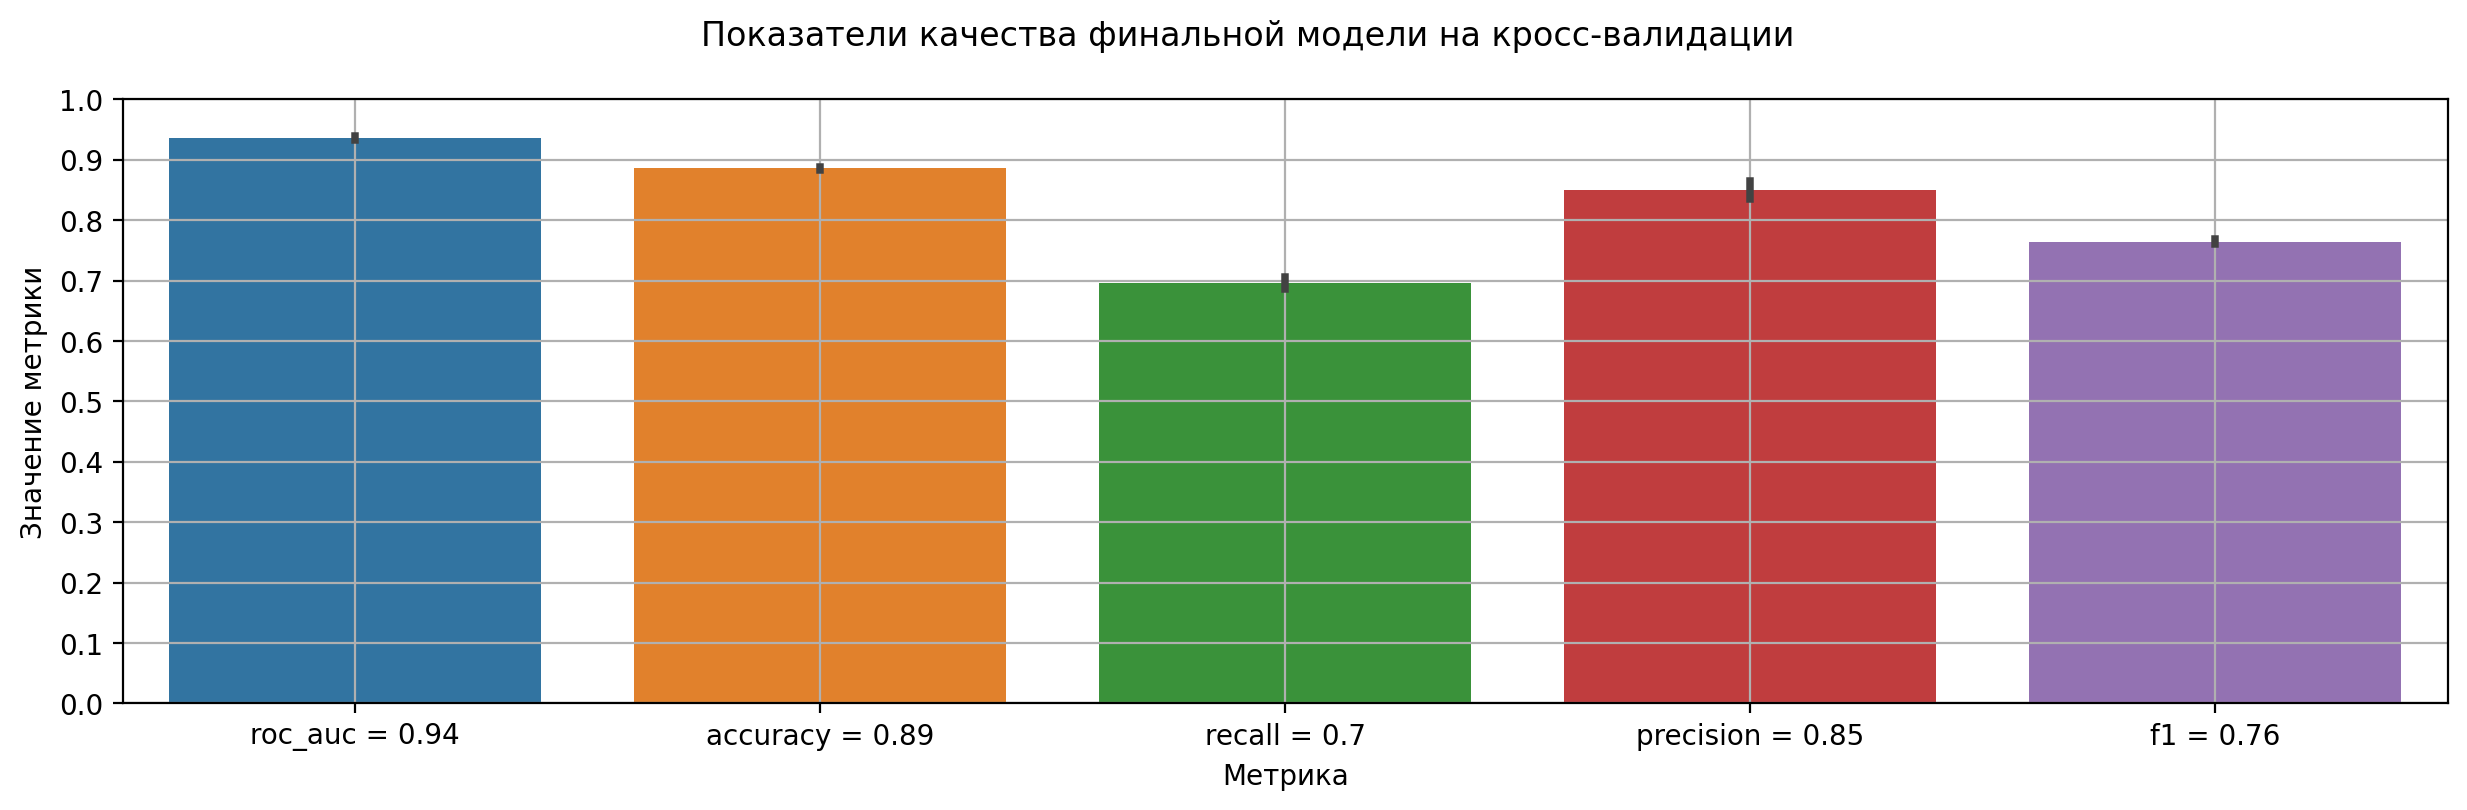

In [78]:
# Сохраним финальную статистику по кросс-валидации
final_stats = pd.DataFrame(cv_pipeline(model, data_final)[0]).drop(['fit_time', 'score_time'], axis=1)

# Выведем средние показатели модели
with Img('Показатели качества финальной модели на кросс-валидации', grid=True):
    sns.barplot(data=final_stats)
    # Сделаем больше делений на шкале
    plt.yticks(np.arange(0, 1.1, .1))
    # Добавим значения метрик к тикам для понятности
    plt.xticks(range(final_stats.columns.shape[0]), [f'{k[5:]} = {v:.2}' for k, v in final_stats.mean().iteritems()])
    Img.labels('Метрика', 'Значение метрики')

- ROC-AUC более чем достаточный по условию нашей задачи.
- Accuracy модели - 89%. Можно сказать, что существует 89% вероятность, что модель правильно классифицирует пользователя.
- Recall ответов не самый высокий: из всех реальных беглецов модель угадывает около 70%.
- Precision = 0.85 - неплохой результат: если мы назыаем человека беглецом, то существует значительная вероятность, что этот человек действительно потенциальный беглец.
- F1 не слишком высокая: Recall тянет её вниз. Но если нам потребуется немного повысить Recall ценой Precision, то мы сможем это сделать, понизив порог вероятности при предсказаниях.

---

## 4. Общий вывод
- Мы загрузили и предобработали данные клиентов, посмотрели на распределения признаков и их зависимости, сделали предположения о том, какие данные помогут нам предсказывать отток клиентов.
- Обучили большое количество моделей, чтобы выбрать ту, которая имеет наибольший потенциал. Наш выбор остановился на XGBoost, и мы выбрали её в качестве базовой модели, дающей лучший результат без дополнительных усилий.
- Попробовали различные приёмы работы с признаками: удаление, кодирование, замена на кластеры KMeans, поочерёдное удаление самых малозначимых признаков.
- Оптимизировали гиперпараметры модели с помощью `GridSearchCV`.
- Наш конечный результат получился впечатляющим: ROC-AUC модели с запасом удовлетворяет условию проекта и в среднем составляет 0.94.

---